In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib

import delta
import napari


In [2]:
def plot_spatial_map(pos, df, property, frame=-1):
   #pos: delta position object
   #lin: delta linage object
   #property: key of cell property contained in lineage object
   #frame: frame to show, if not specified last one is chosen
   #axis: axis to add plot to, if not specified new one is made
   
   #create color map where Nan is shown as black  
   colMap = cm.get_cmap("viridis").copy()
   colMap.set_bad(color='black')
   
   #get frame
   frame = len(pos.rois[0].label_stack)-1 if frame==-1 else frame

   # get label image:
   labels = pos.rois[0].label_stack[frame]
   spatial_map = np.full(labels.shape, np.nan)
   
   # Go over cells in selected frame:
   for cnb in np.unique(labels):
      if cnb==0: continue
      #assign cells mask area the phenotype of choice
      spatial_map[labels==cnb] = df.loc[(df['frames']==frame) & (df['id_seg']==cnb-1),property].item()
   
   return spatial_map

## Load Data
We load the data from the last notebook;

In [37]:
pos_file = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Andreas/output/pkl_files/TL01_29/Position000000.pkl')
df_file = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Andreas/output/csv_files/AKS1092_TL01_29.csv')

#postion object
pos = delta.pipeline.Position(None,None,None)
pos.load(pos_file)
df = pd.read_csv(df_file)

labels = pos.rois[0].label_stack
imstack = np.stack(pos.rois[0].img_stack, axis=0) #load image data from position file
labelstack = np.stack(labels, axis=0) #load label data from position file

props = [plot_spatial_map(pos, df, 'id_colony', frame=fr) for fr in range(len(labels))]
propstack = np.stack(props) #load label data from position file

viewer = napari.view_image(imstack)
viewer.add_labels(labelstack)
viewer.add_image(propstack, colormap='inferno')
viewer.show()

## Select sub colonies

In [9]:
df_col1 = df.loc[(df['id_colony']==2) | (df['id_colony']==3)]

## Check colony tracking with Napari

In [11]:
#create matrix with lin_id, and (t,x,y) coordinates
lin_data = np.vstack([df_col1["id_cell"].to_numpy(dtype=int), 
                      df_col1["frames"].to_numpy(dtype=int), 
                      df_col1["y_pos"].to_numpy(dtype=int), 
                      df_col1["x_pos"].to_numpy(dtype=int)]).T
lin_data.shape

#create dictionary that link lin_id of cell to lin_id of mother 
lin_id = df_col1["id_cell"].to_numpy(dtype=int)
mom_id = df_col1["id_par"].to_numpy(dtype=int)

#lin_id is a vector that contains many duplicate entries, we remove them using np.unique:
lin_set, idx_set = np.unique(lin_id, return_index=True)
mom_set = mom_id[idx_set]

#init graph dictionary
graph = {}
for linnum, mom in zip(lin_set, mom_set):
    if mom >= 0:
        graph[linnum] = mom


In [12]:
#add tracks to viewer
viewer.add_tracks(lin_data, name='Tracks', graph=graph)
viewer.show()

## Plot overview maps Cc

In [34]:
df_path = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Andreas/output/csv_files/')
save_dir = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Andreas/colony_overview_images')
file_names = [f.name for f in sorted((df_path).glob('*.csv'))]


In [ ]:
for f in file_names:
    dname = f.replace('.csv','')

    df = pd.read_csv(df_path / f)
    df_end = df[df['frames'] == df['frames'].max().item()].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12,12))
    sns.scatterplot(ax=ax, data=df_end, x='x_pos',y='y_pos', s=0)

    for i in range(df_end.shape[0]):
        plt.text(x=df_end.x_pos[i],y=df_end.y_pos[i],s=df_end.id_colony[i], 
            fontdict=dict(color='black',size=6))
    ax.set_title(dname);    
    ax.set_xlim((0,1024))
    ax.set_ylim((0,1024))
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    fig.patch.set_facecolor('white')
    fig.savefig(save_dir / (dname+'.pdf'))

## Plot overview maps Pa

In [3]:
df_path = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Andreas/outputPA/csv_files/')
save_dir = pathlib.Path('/Users/simonvanvliet/switchdrive/Biozentrum/Andreas/colony_overview_imagesPA')
file_names = [f.name for f in sorted((df_path).glob('*.csv'))]


/var/folders/bt/bfw962p91rjdg_tcsz3dh95w0000gn/T/ipykernel_26724/2113862157.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,12))


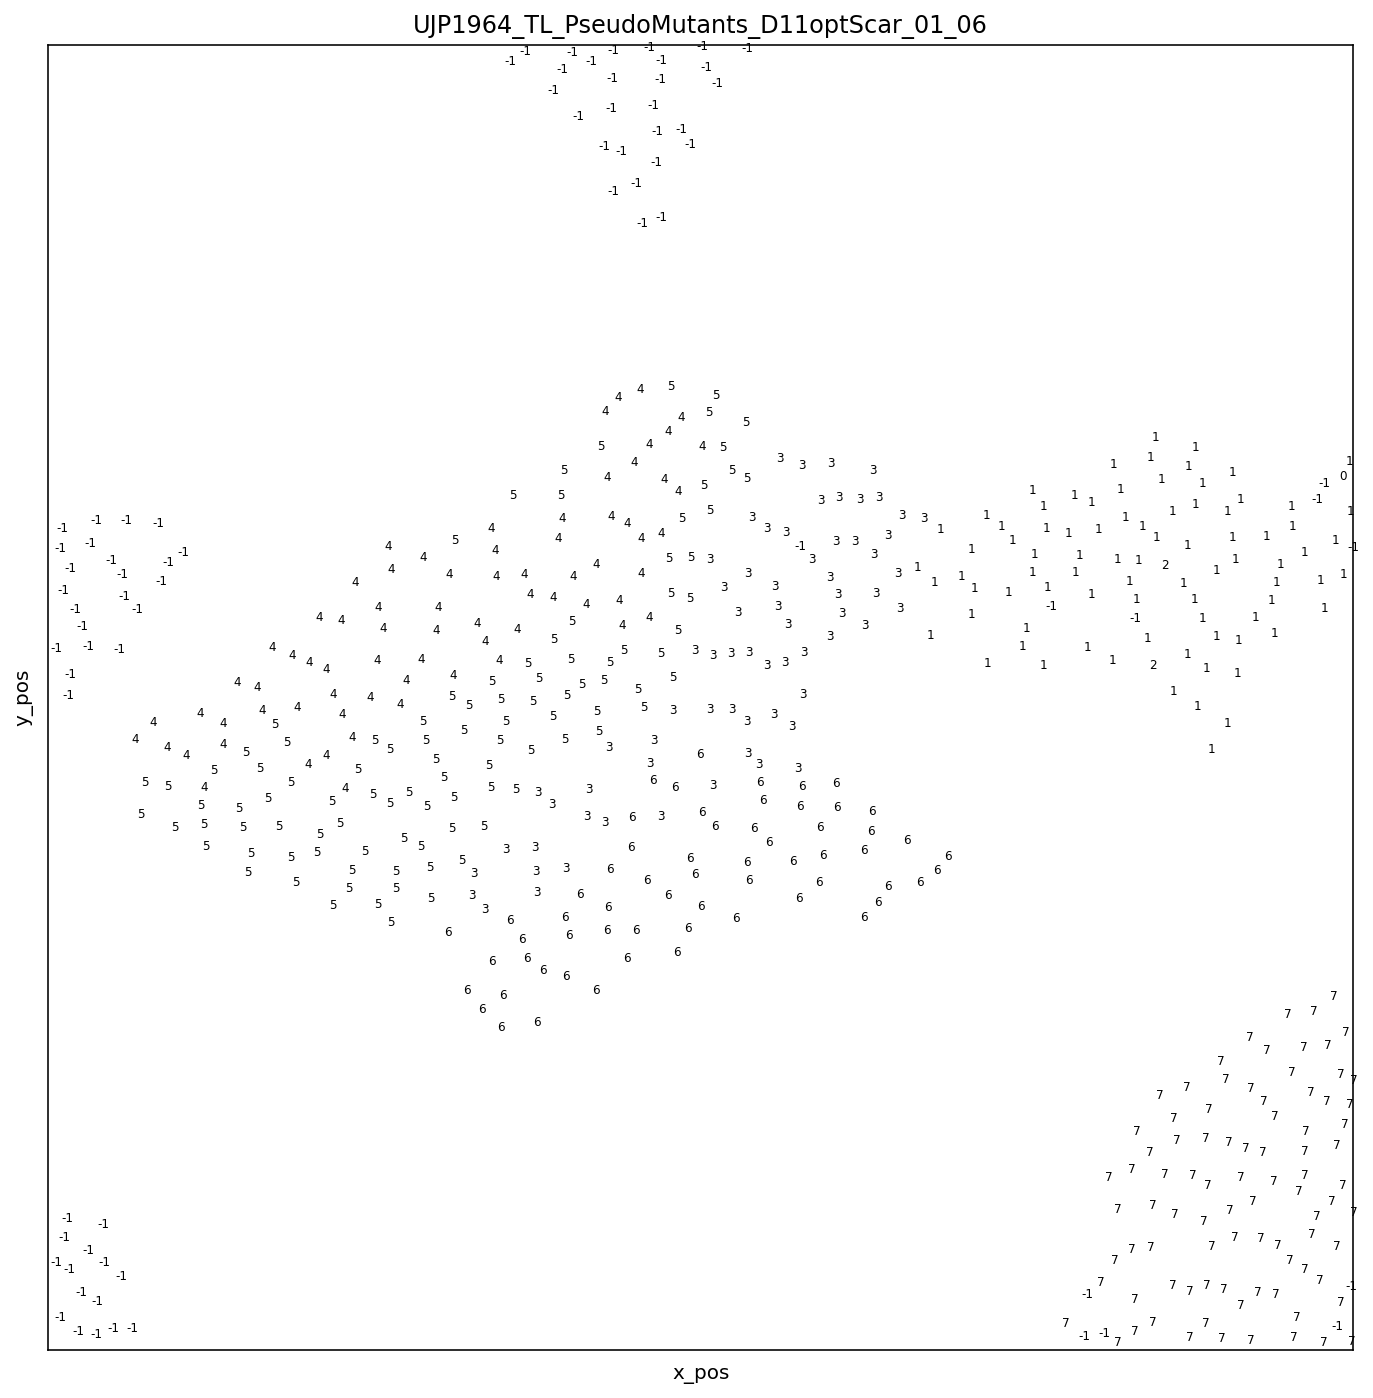

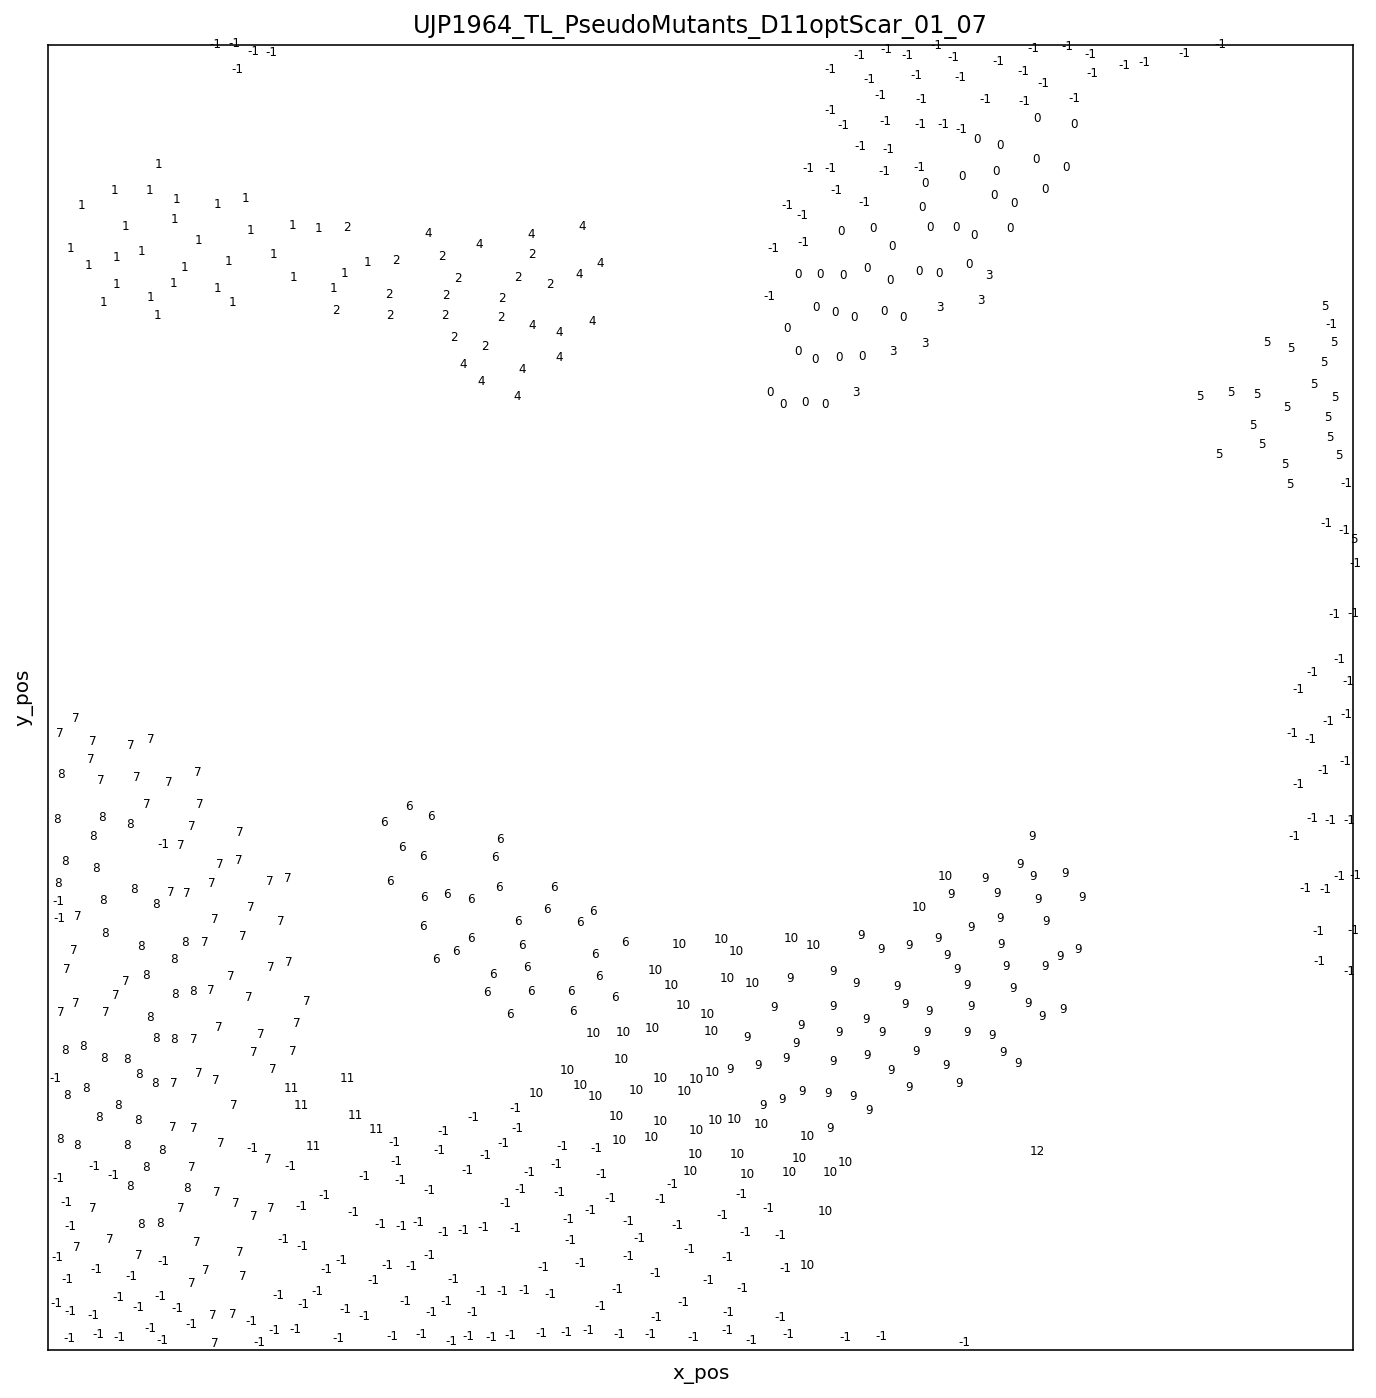

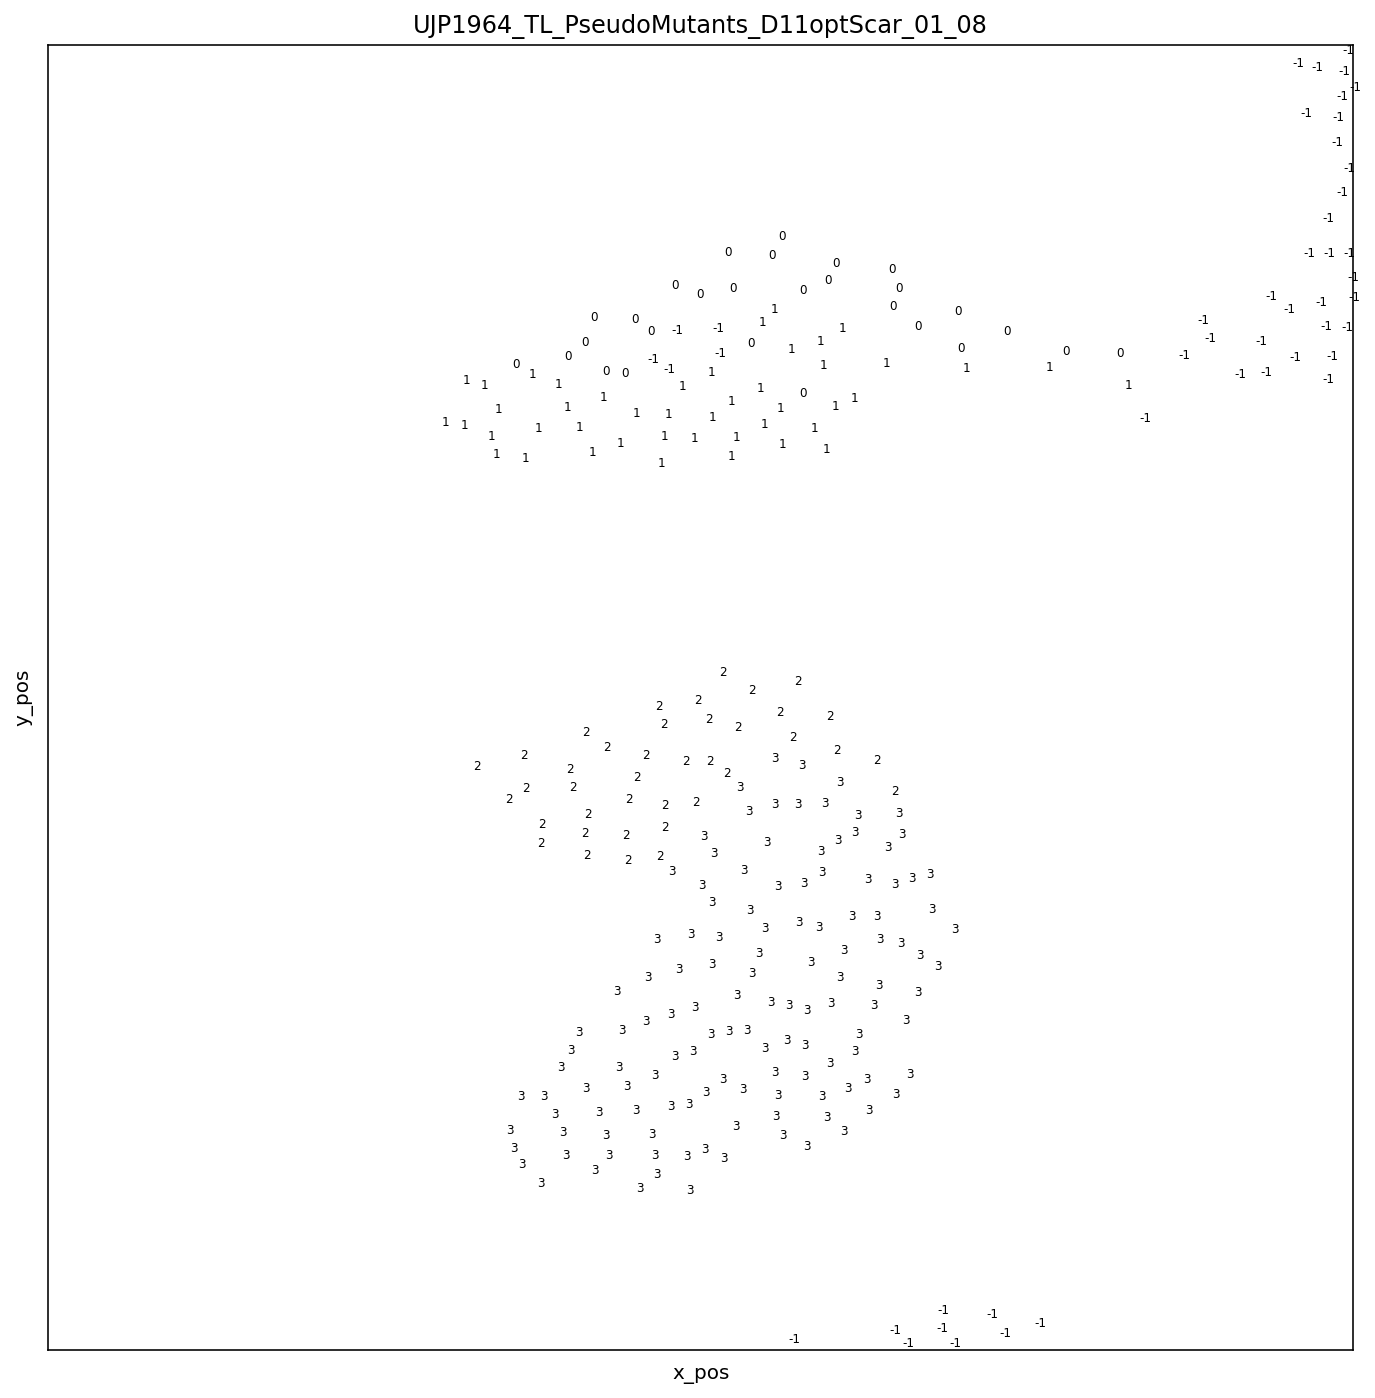

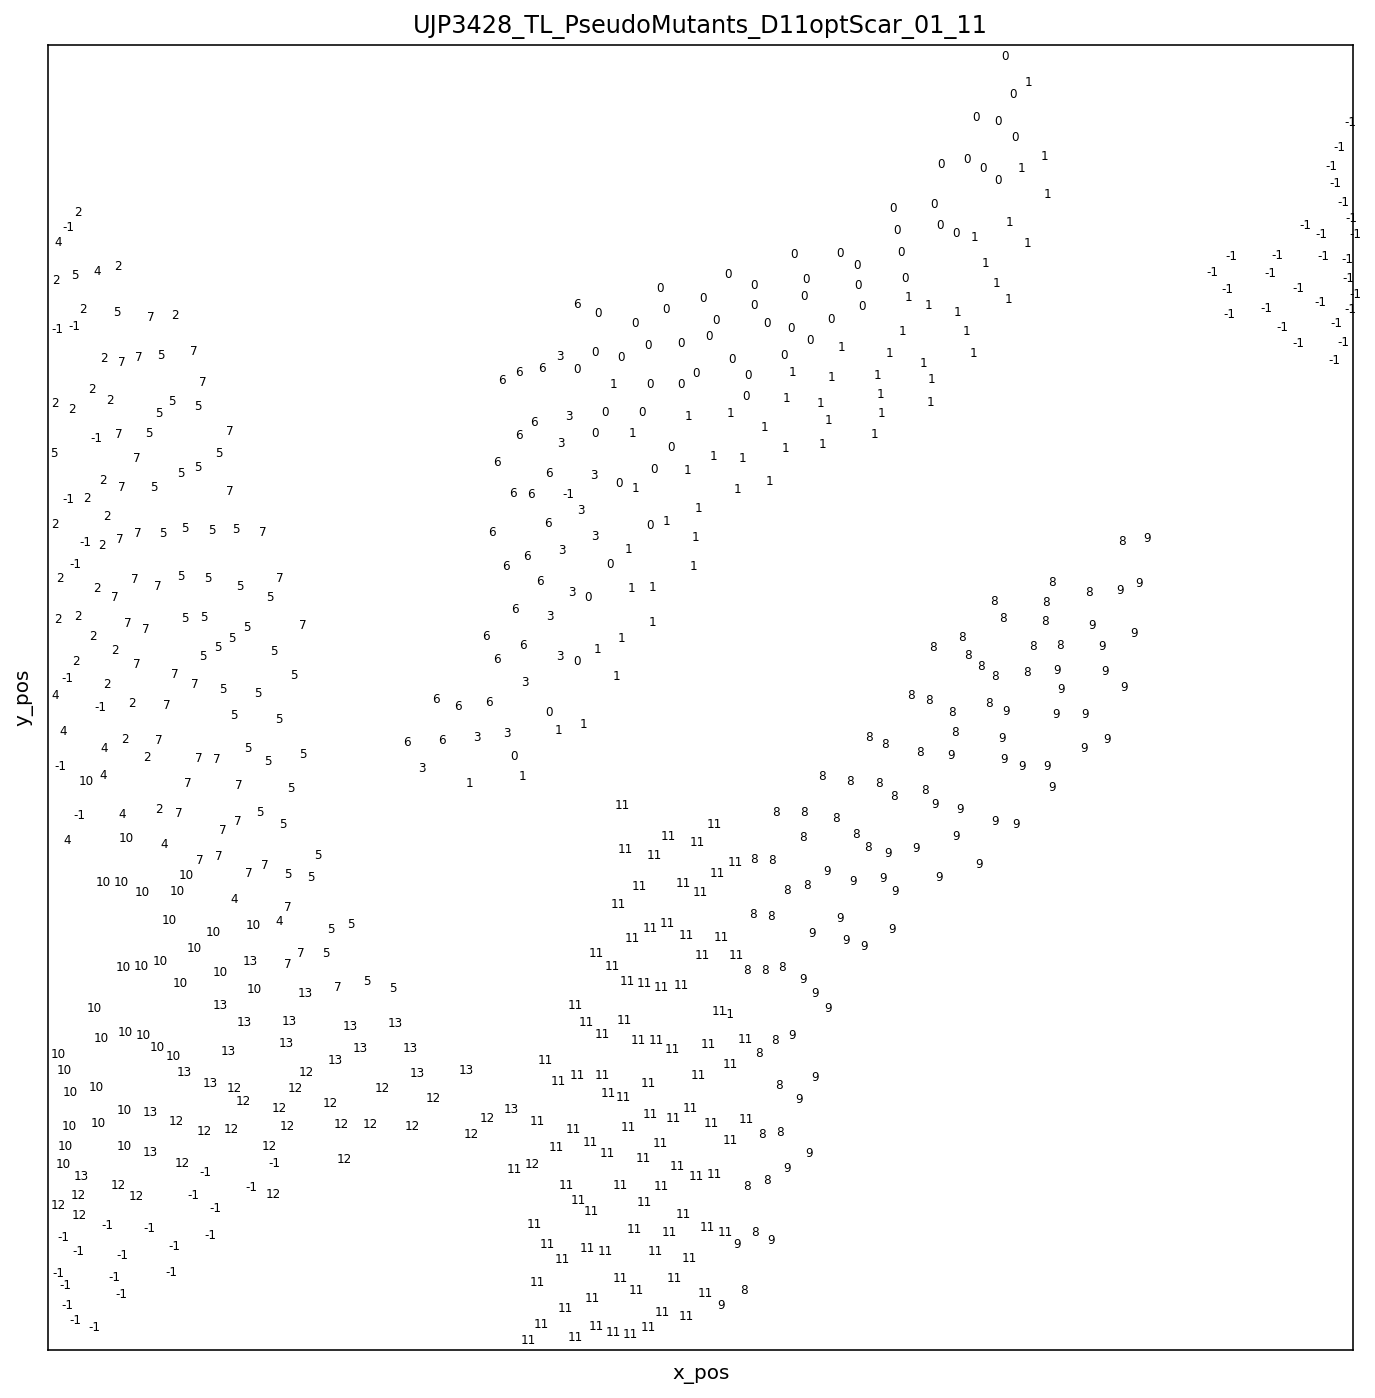

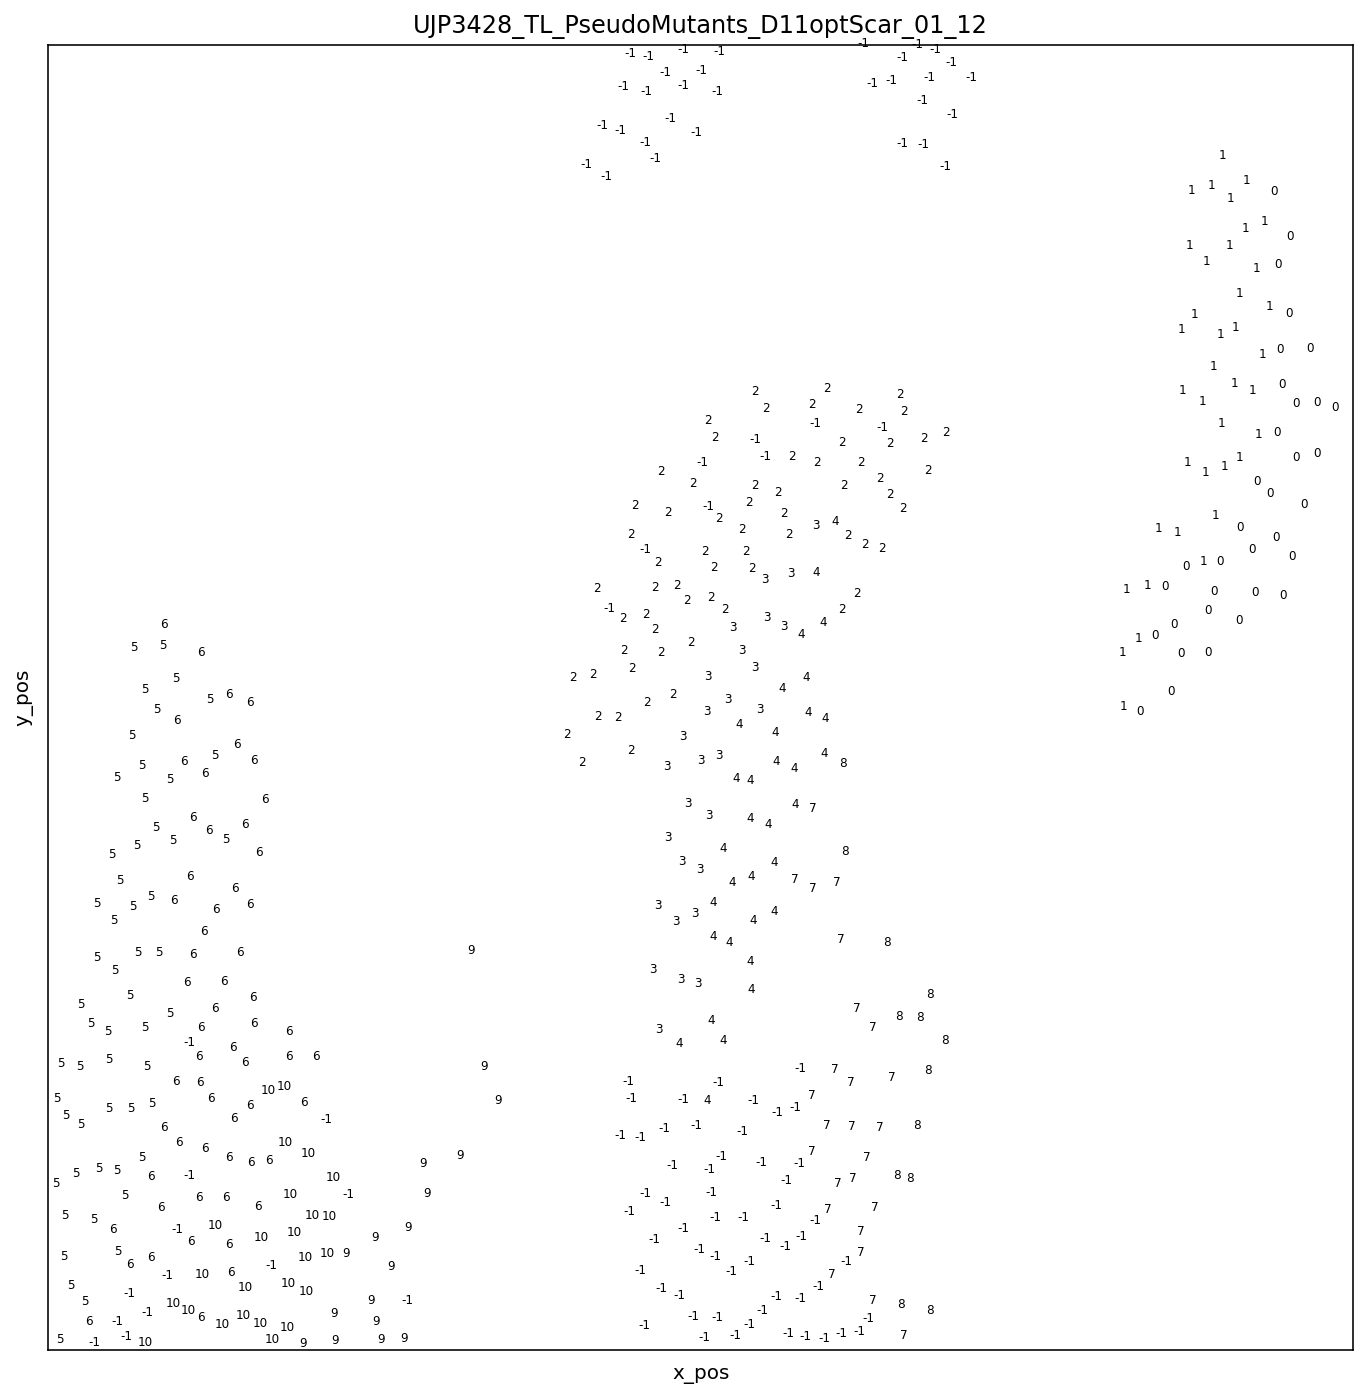

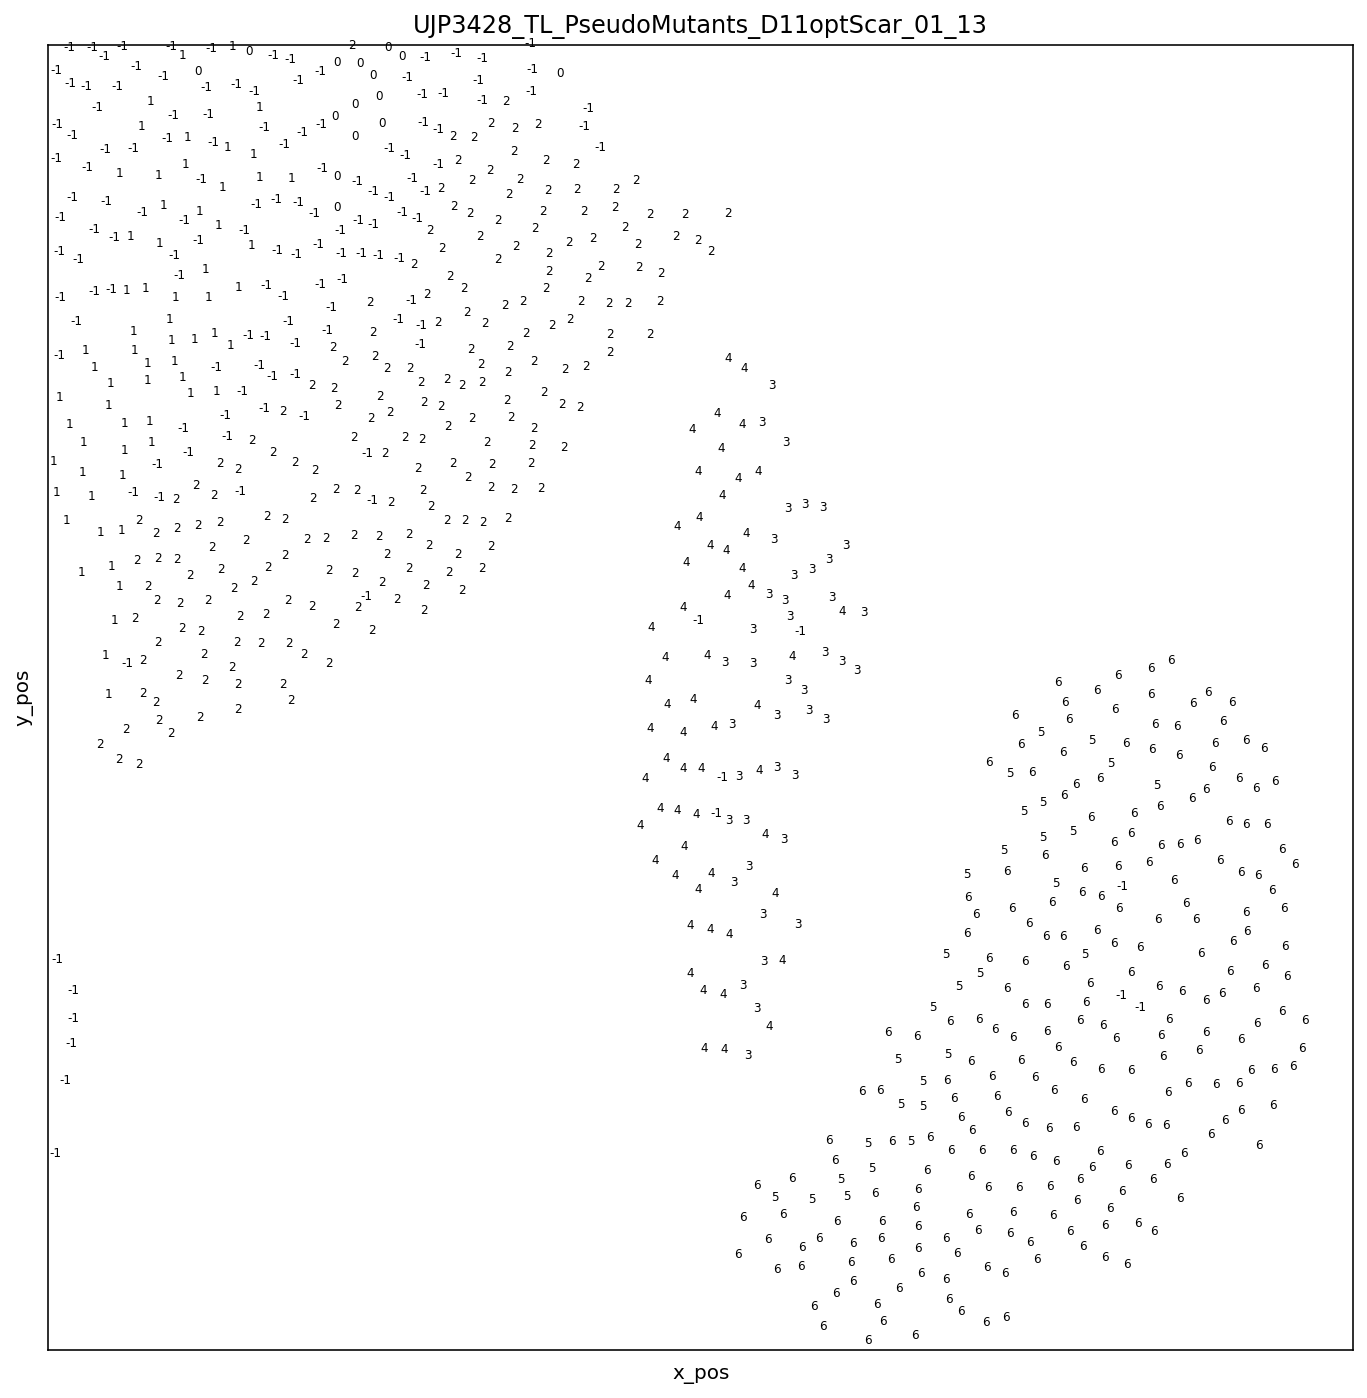

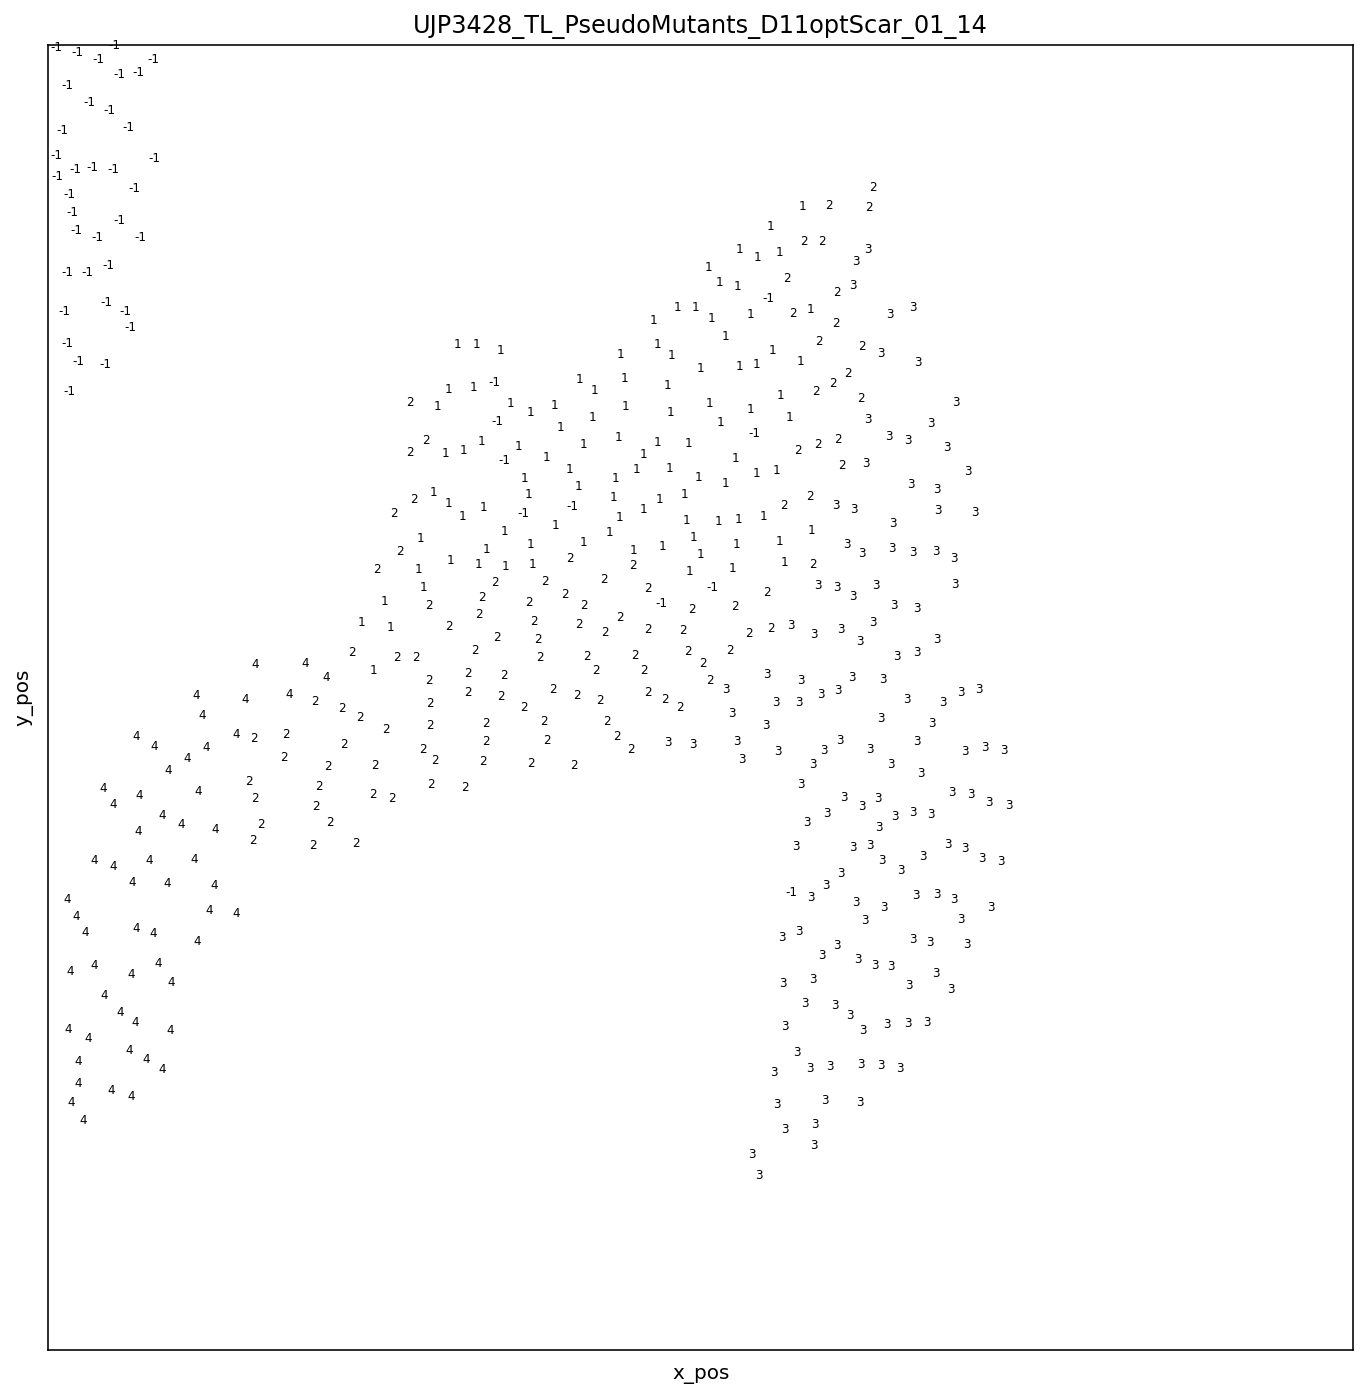

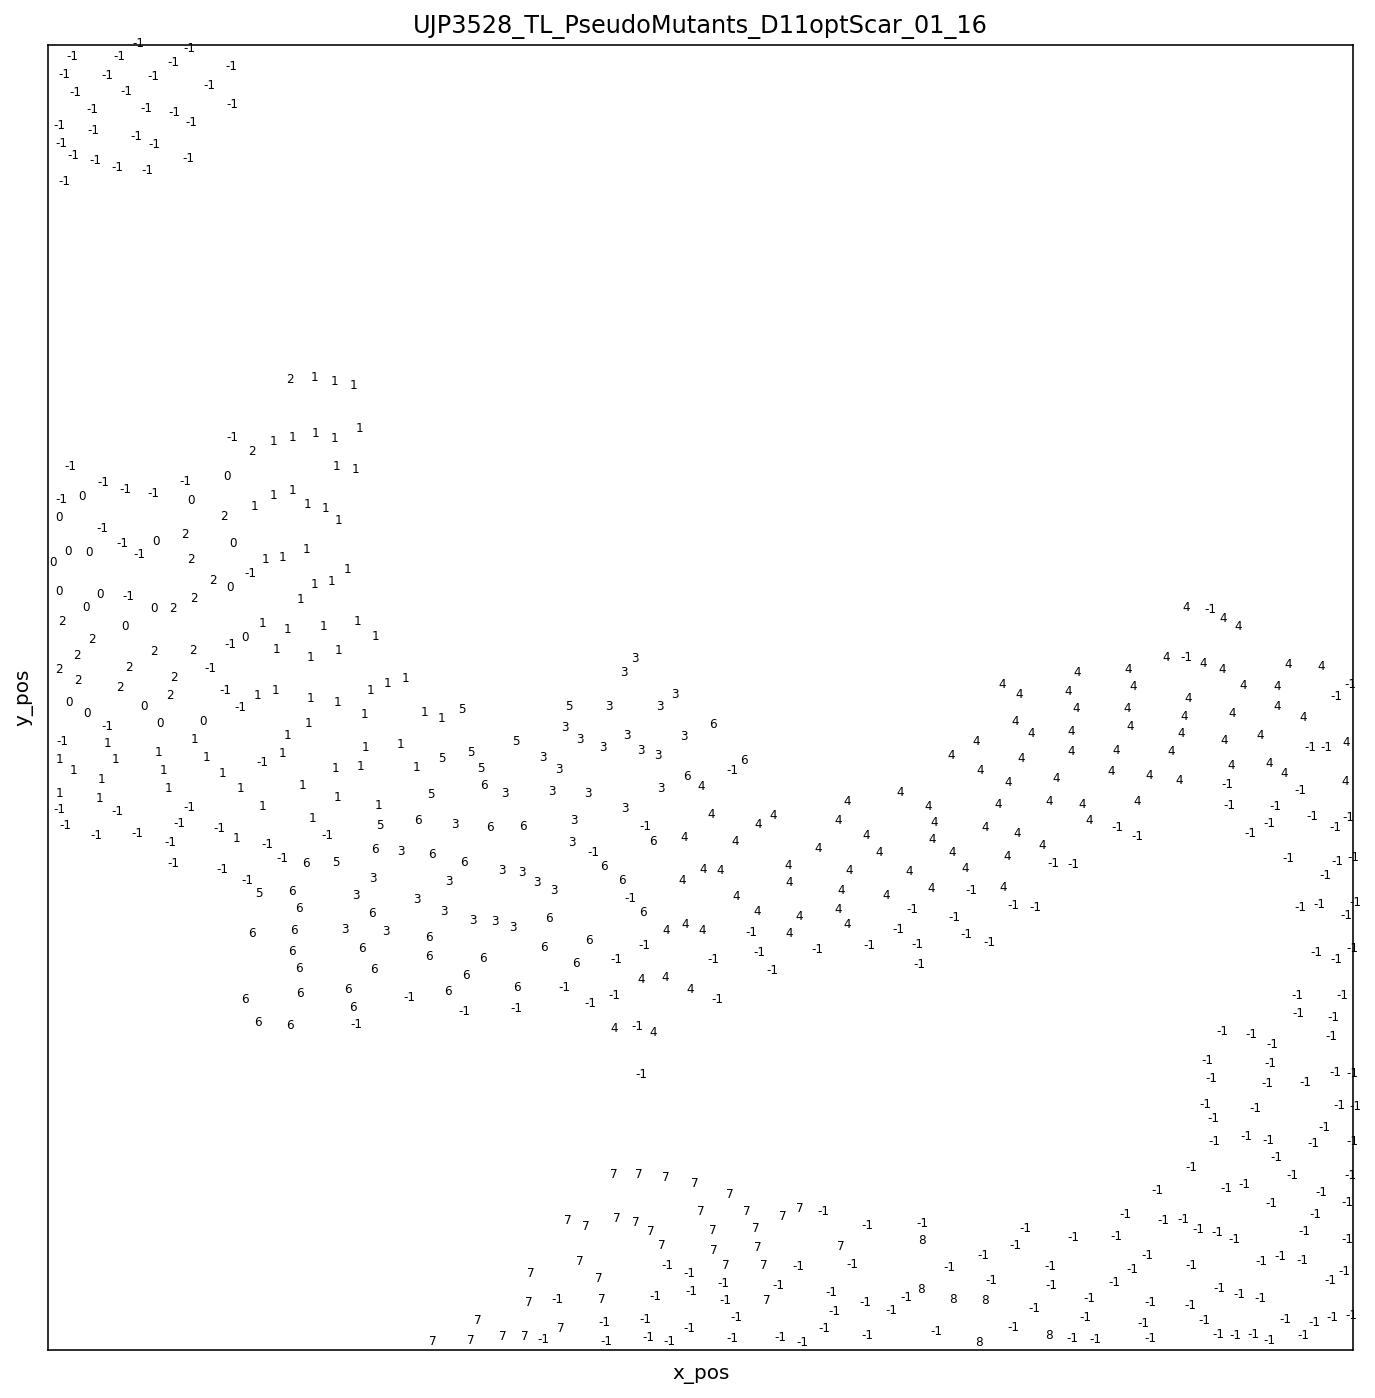

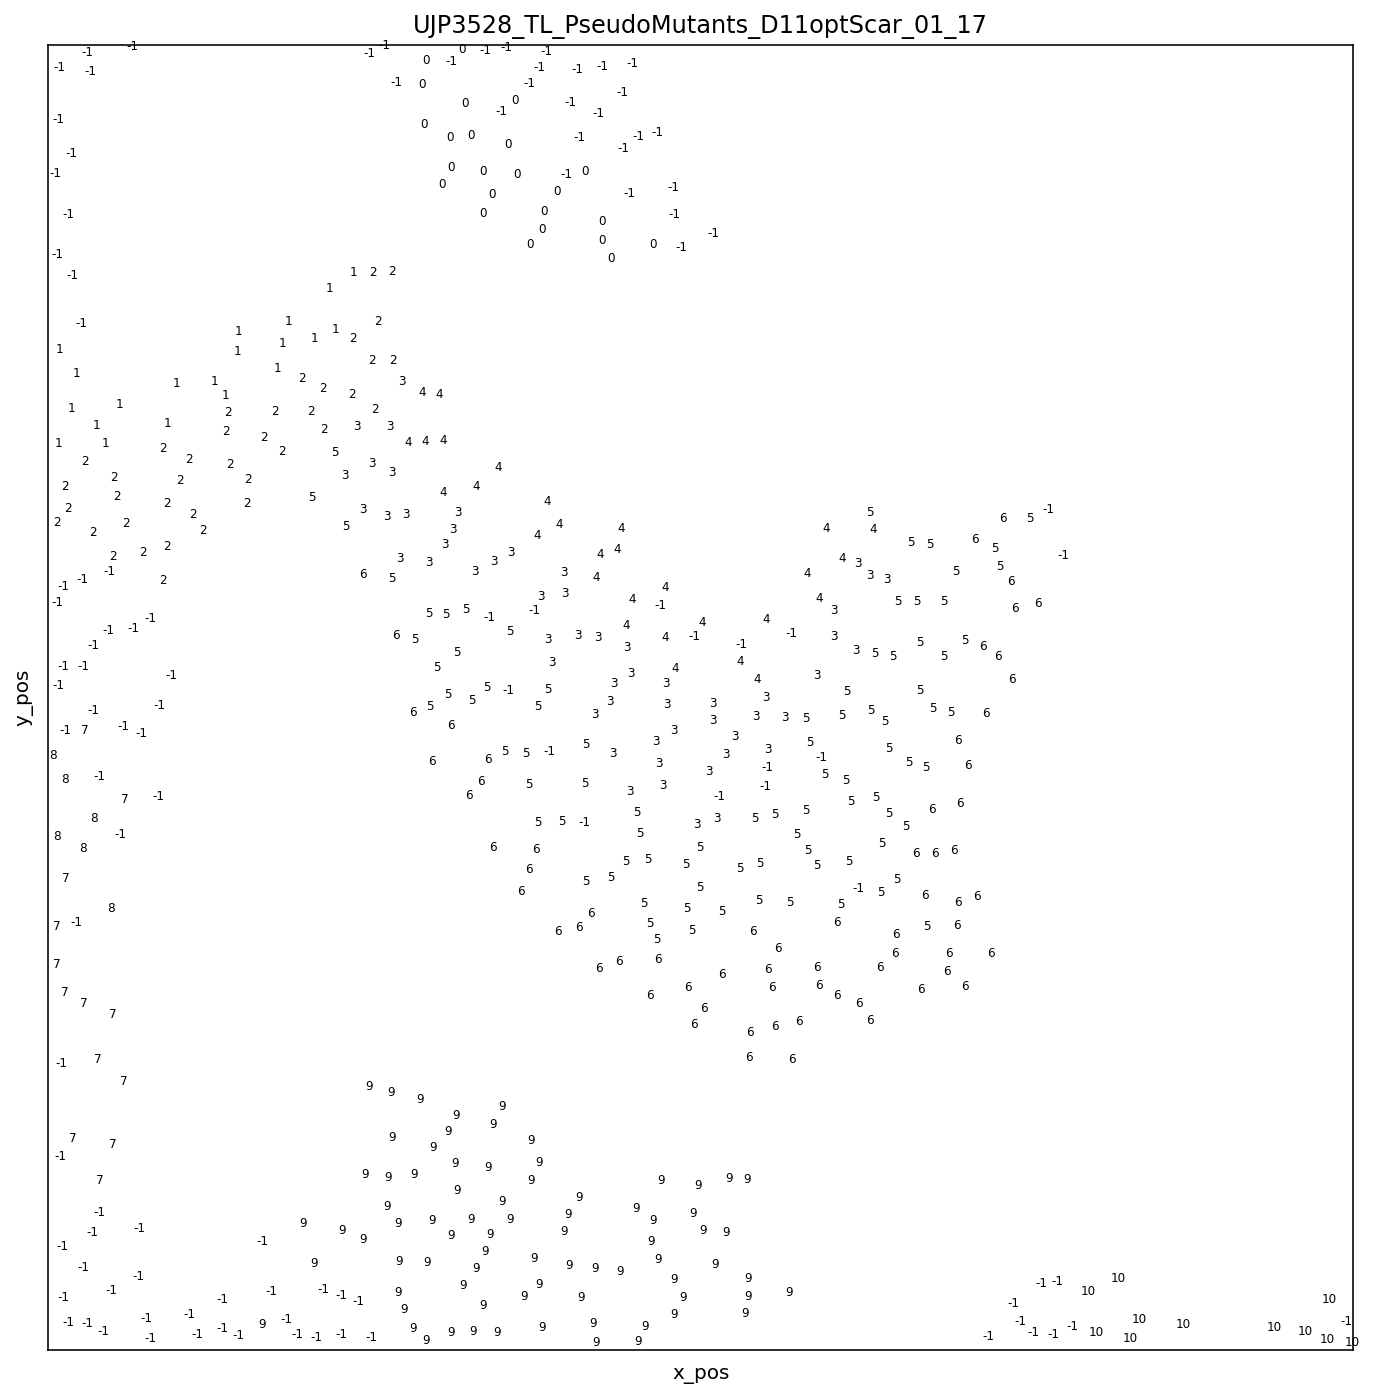

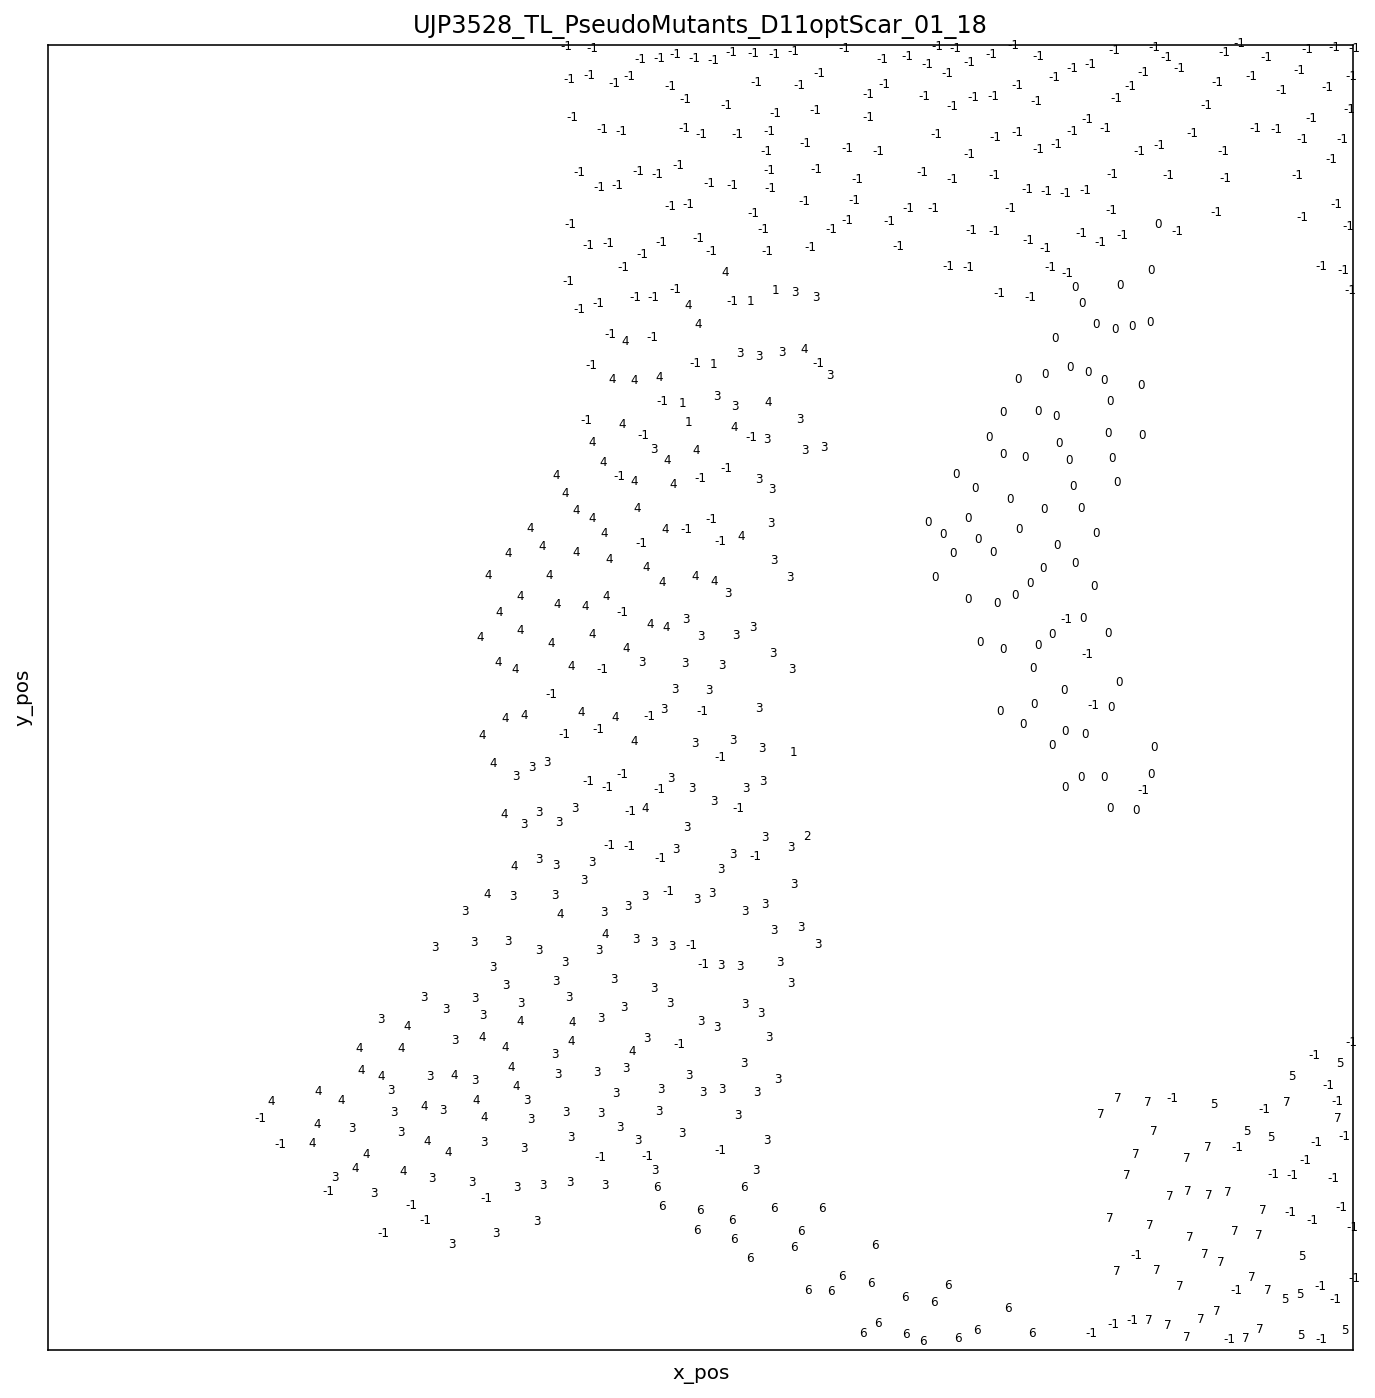

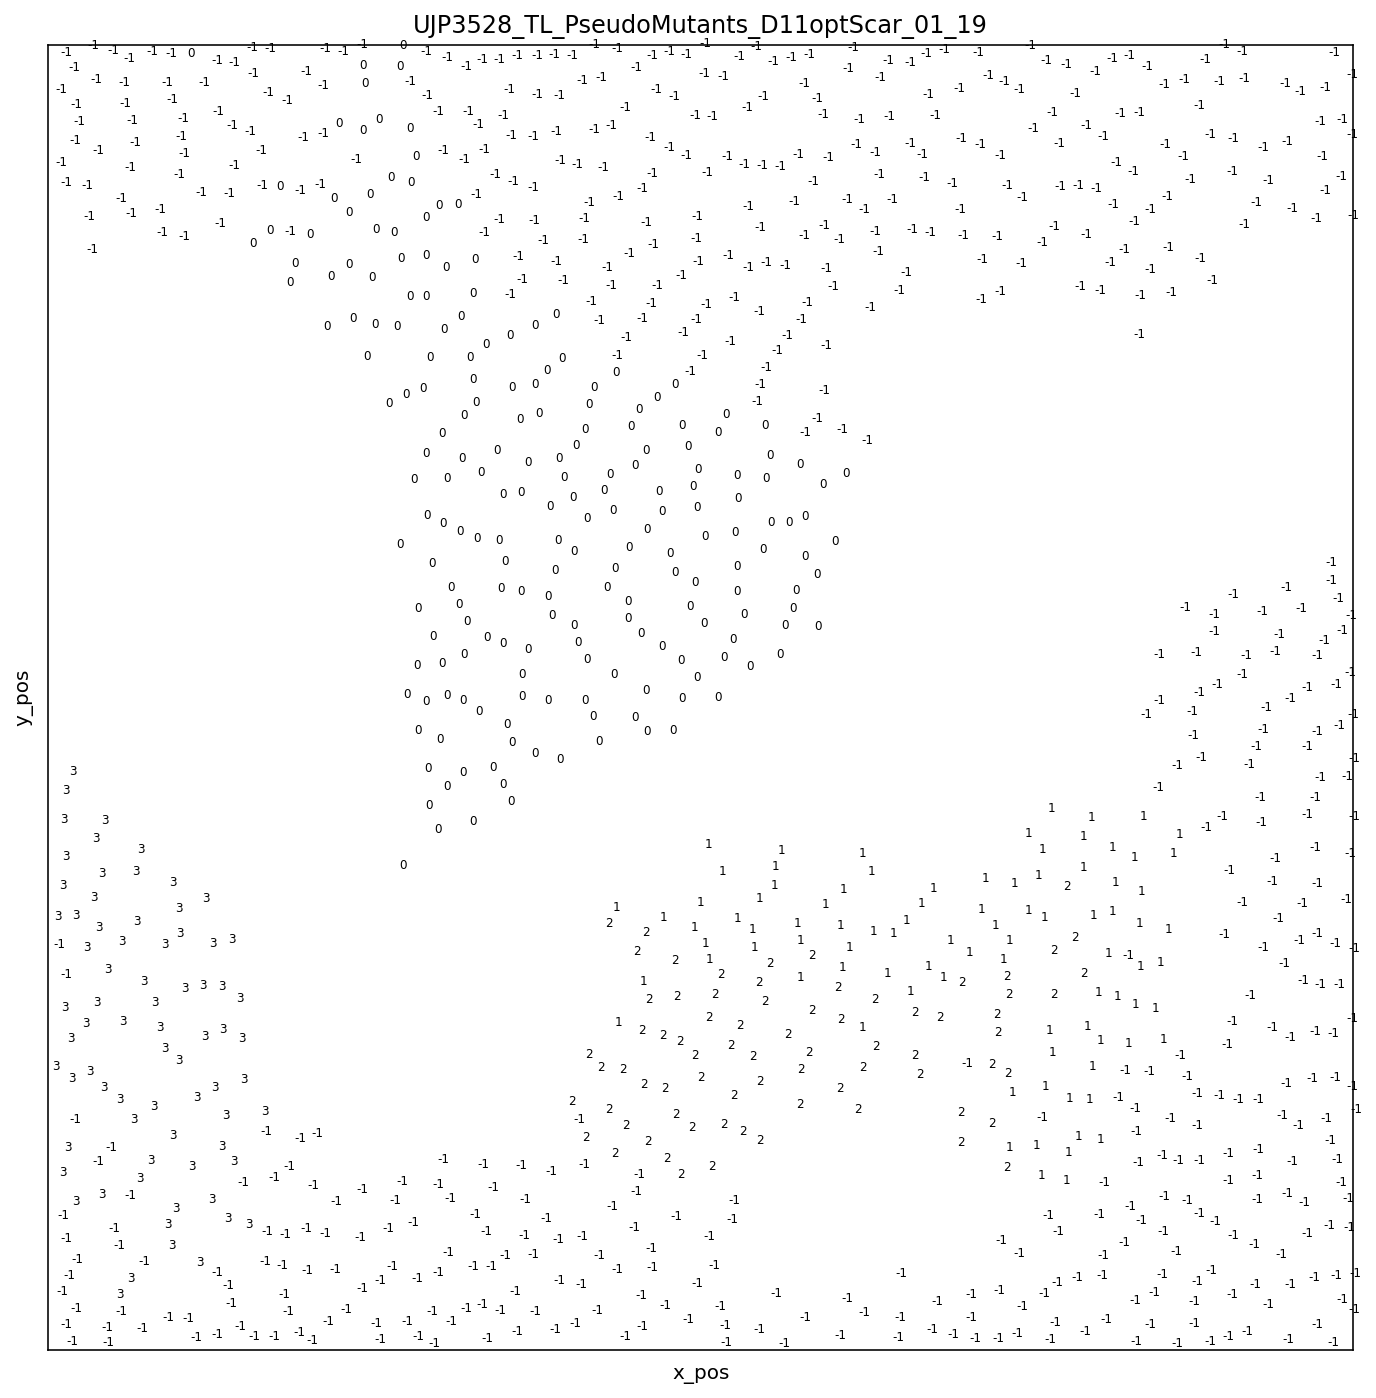

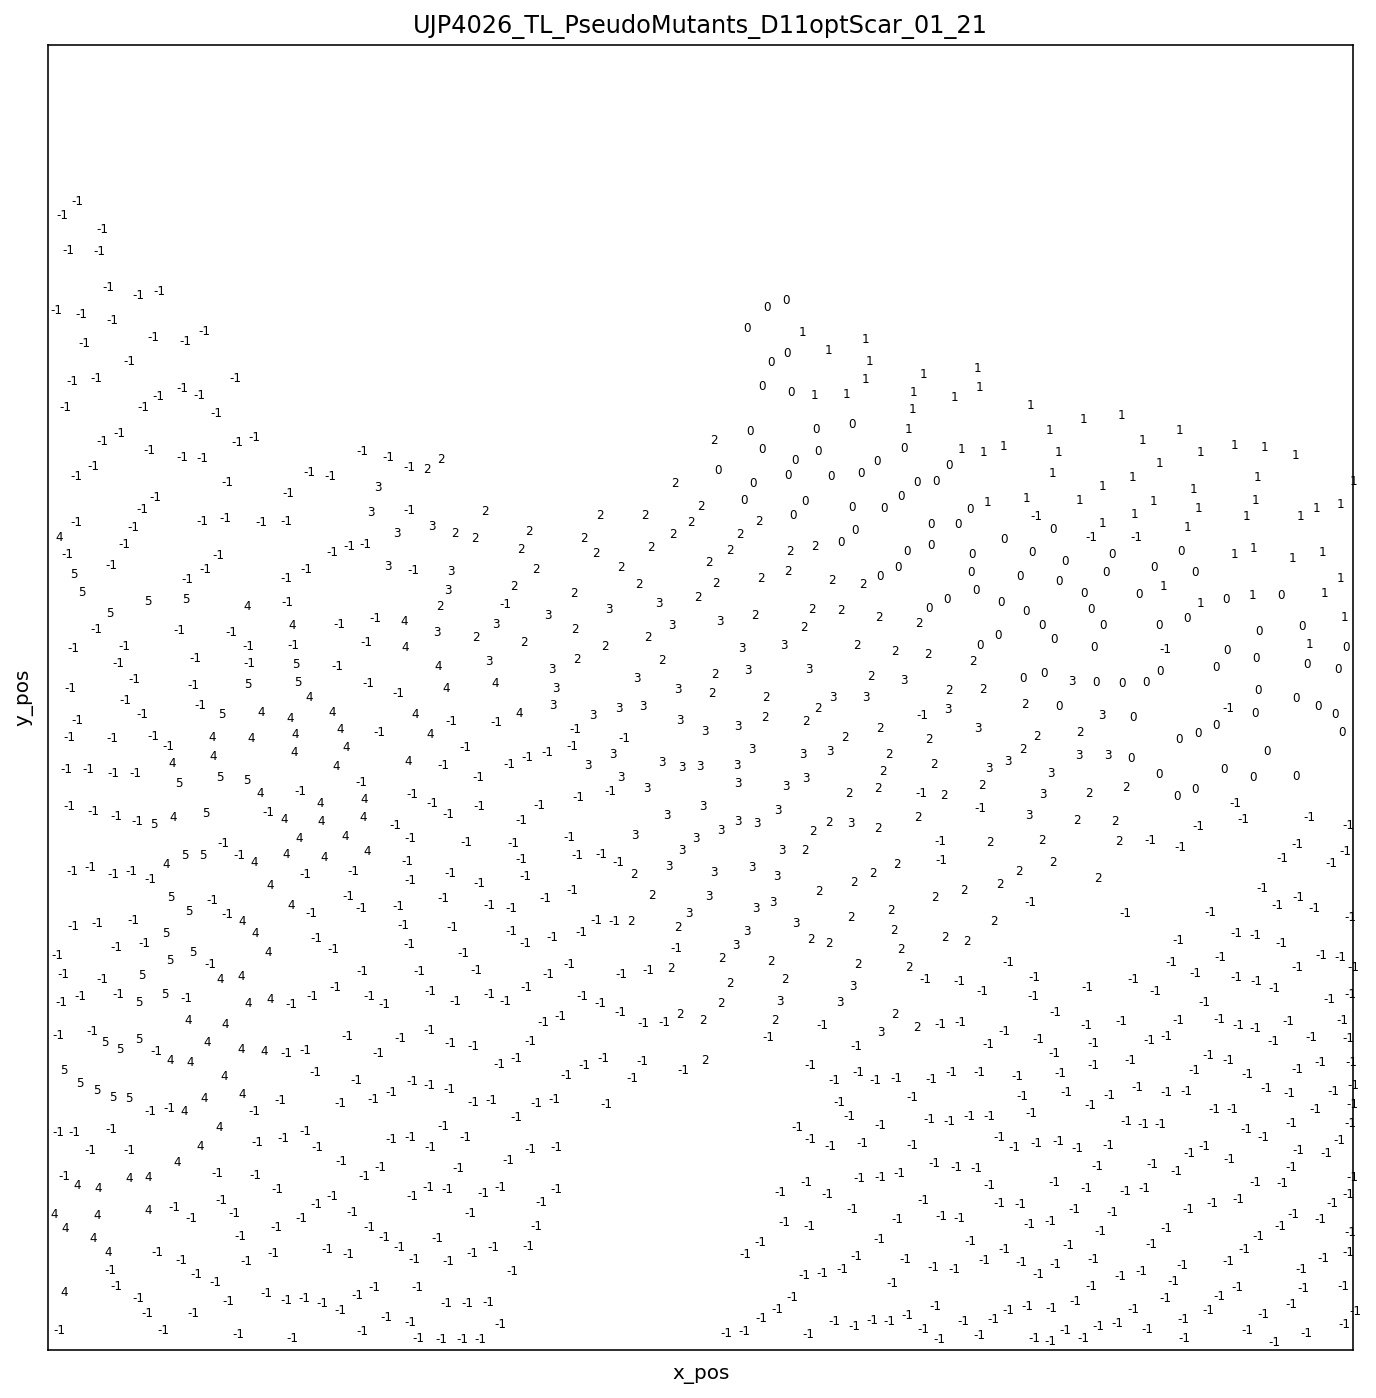

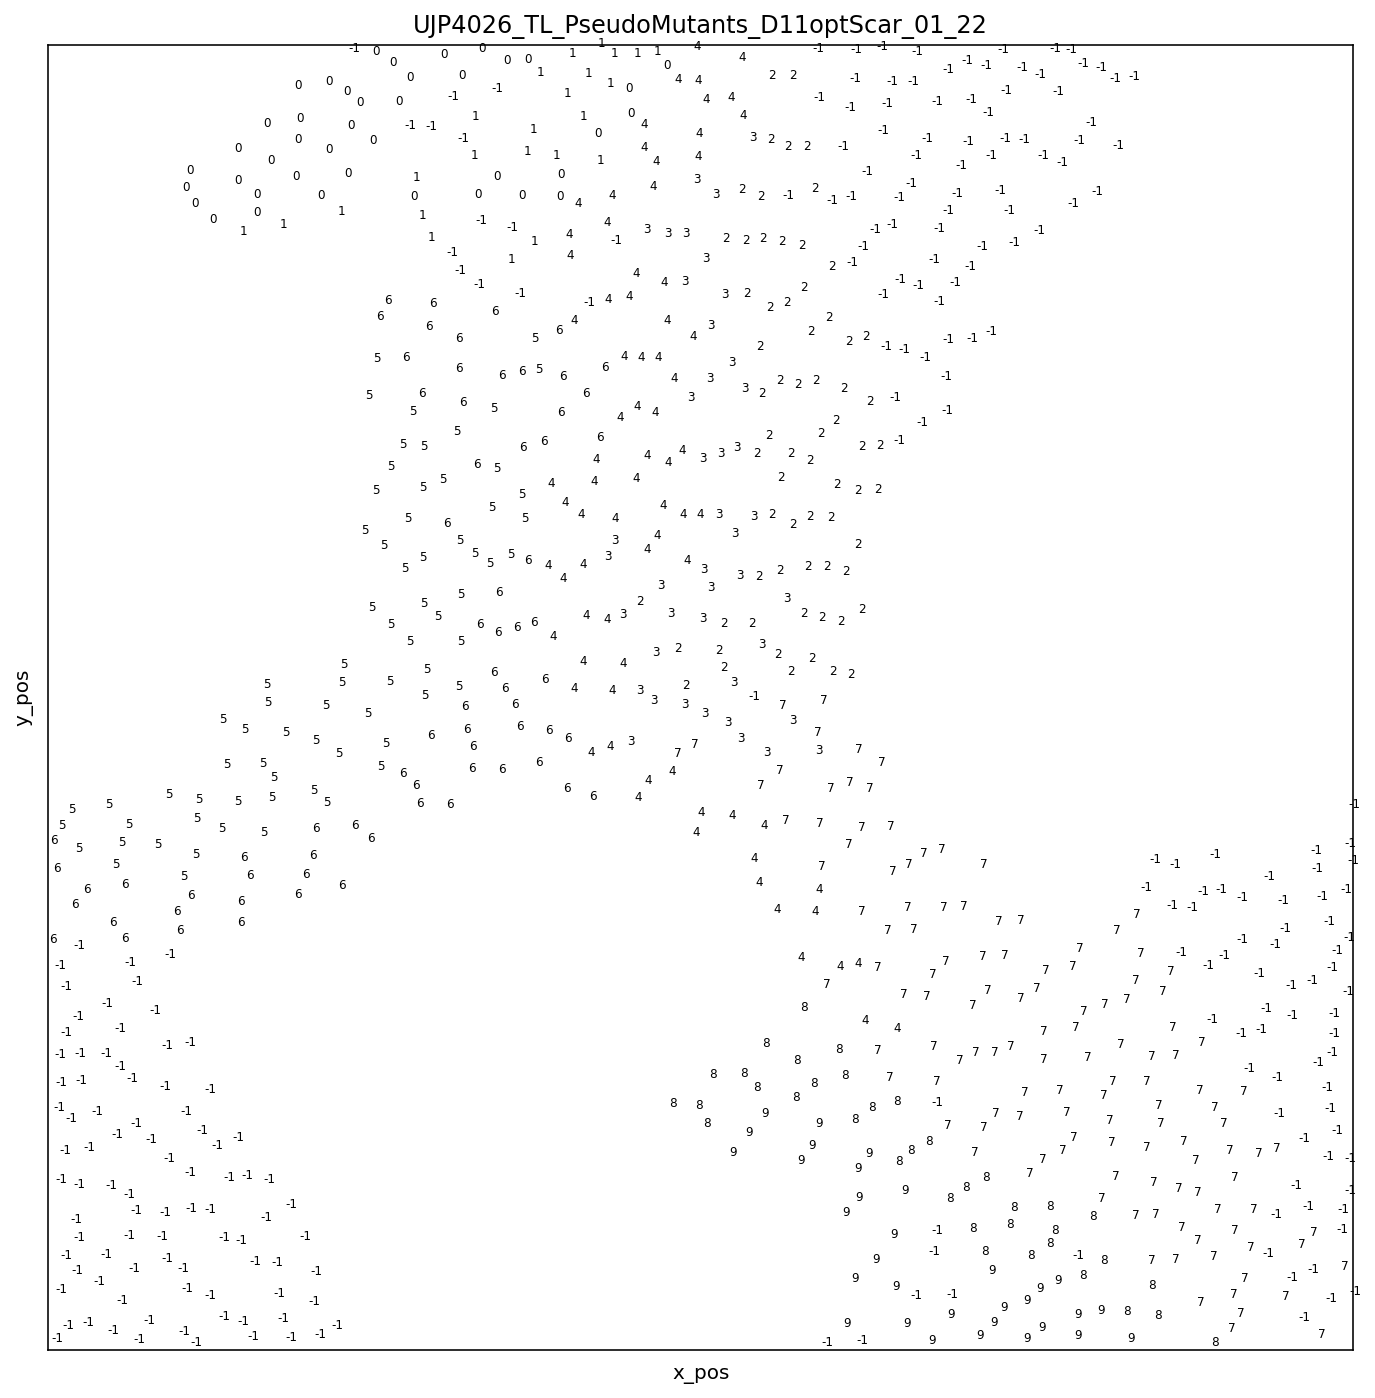

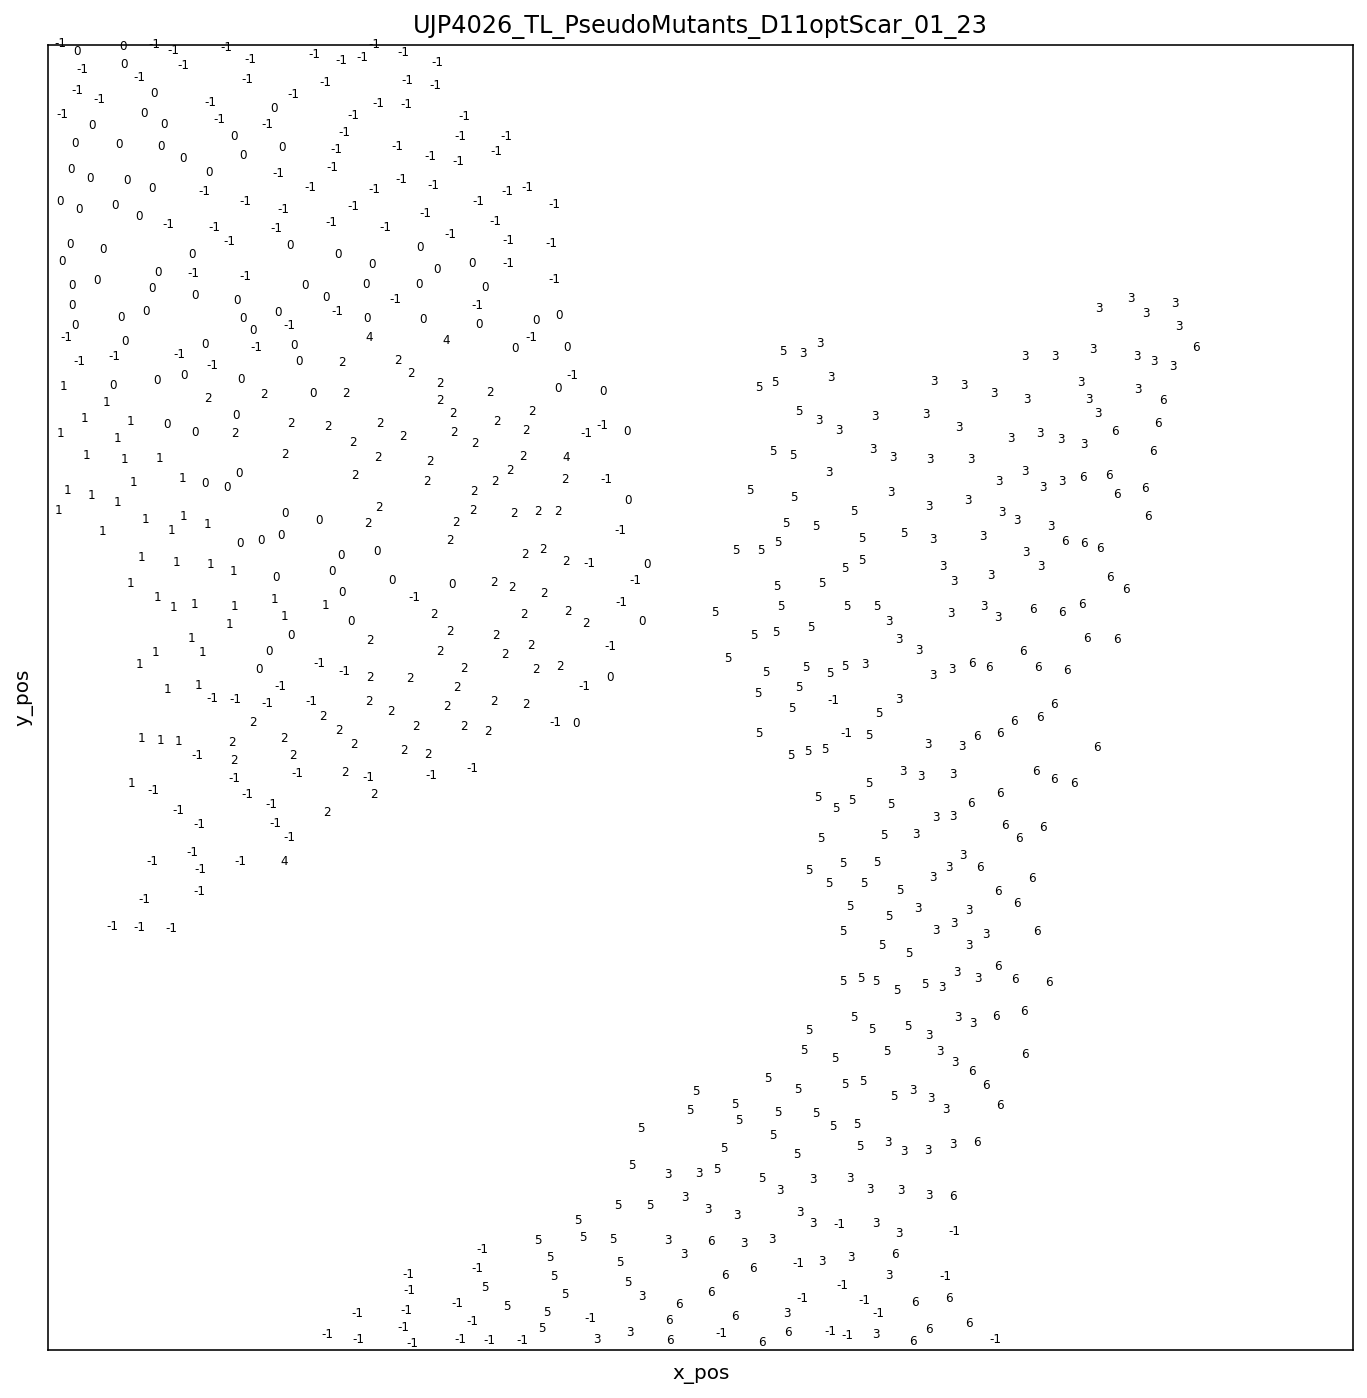

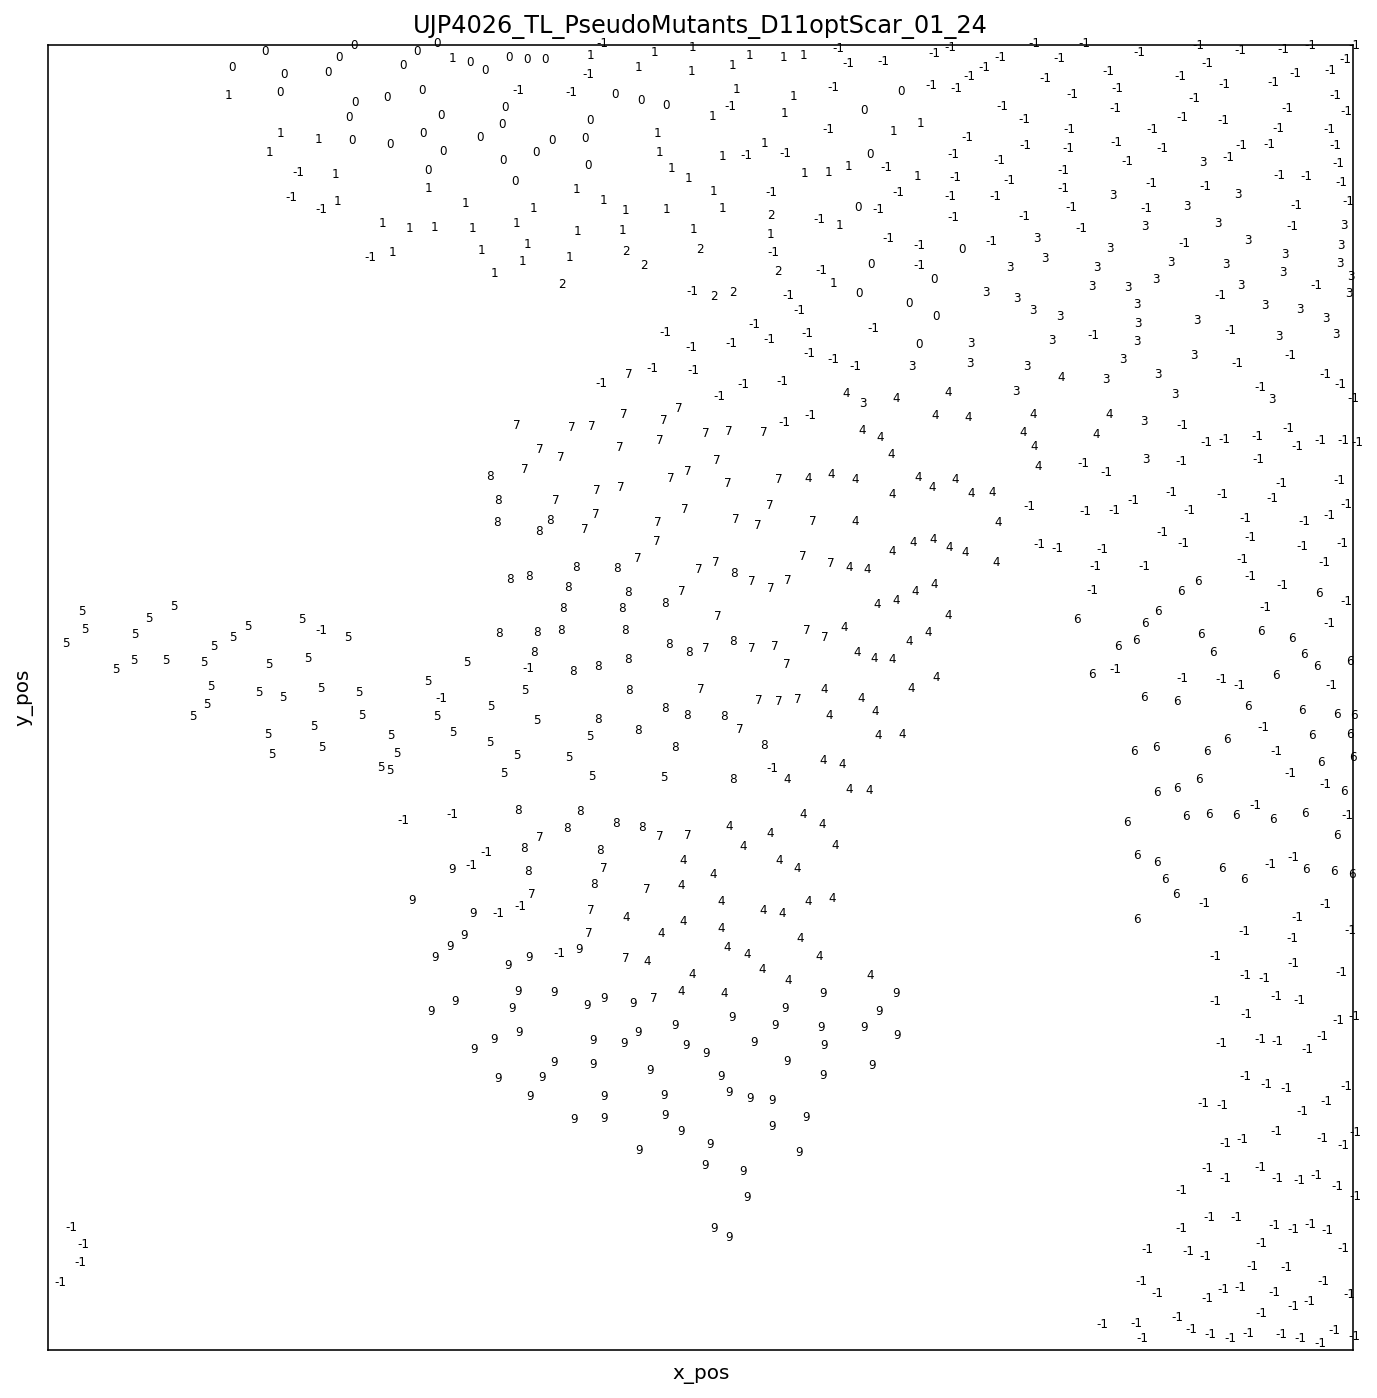

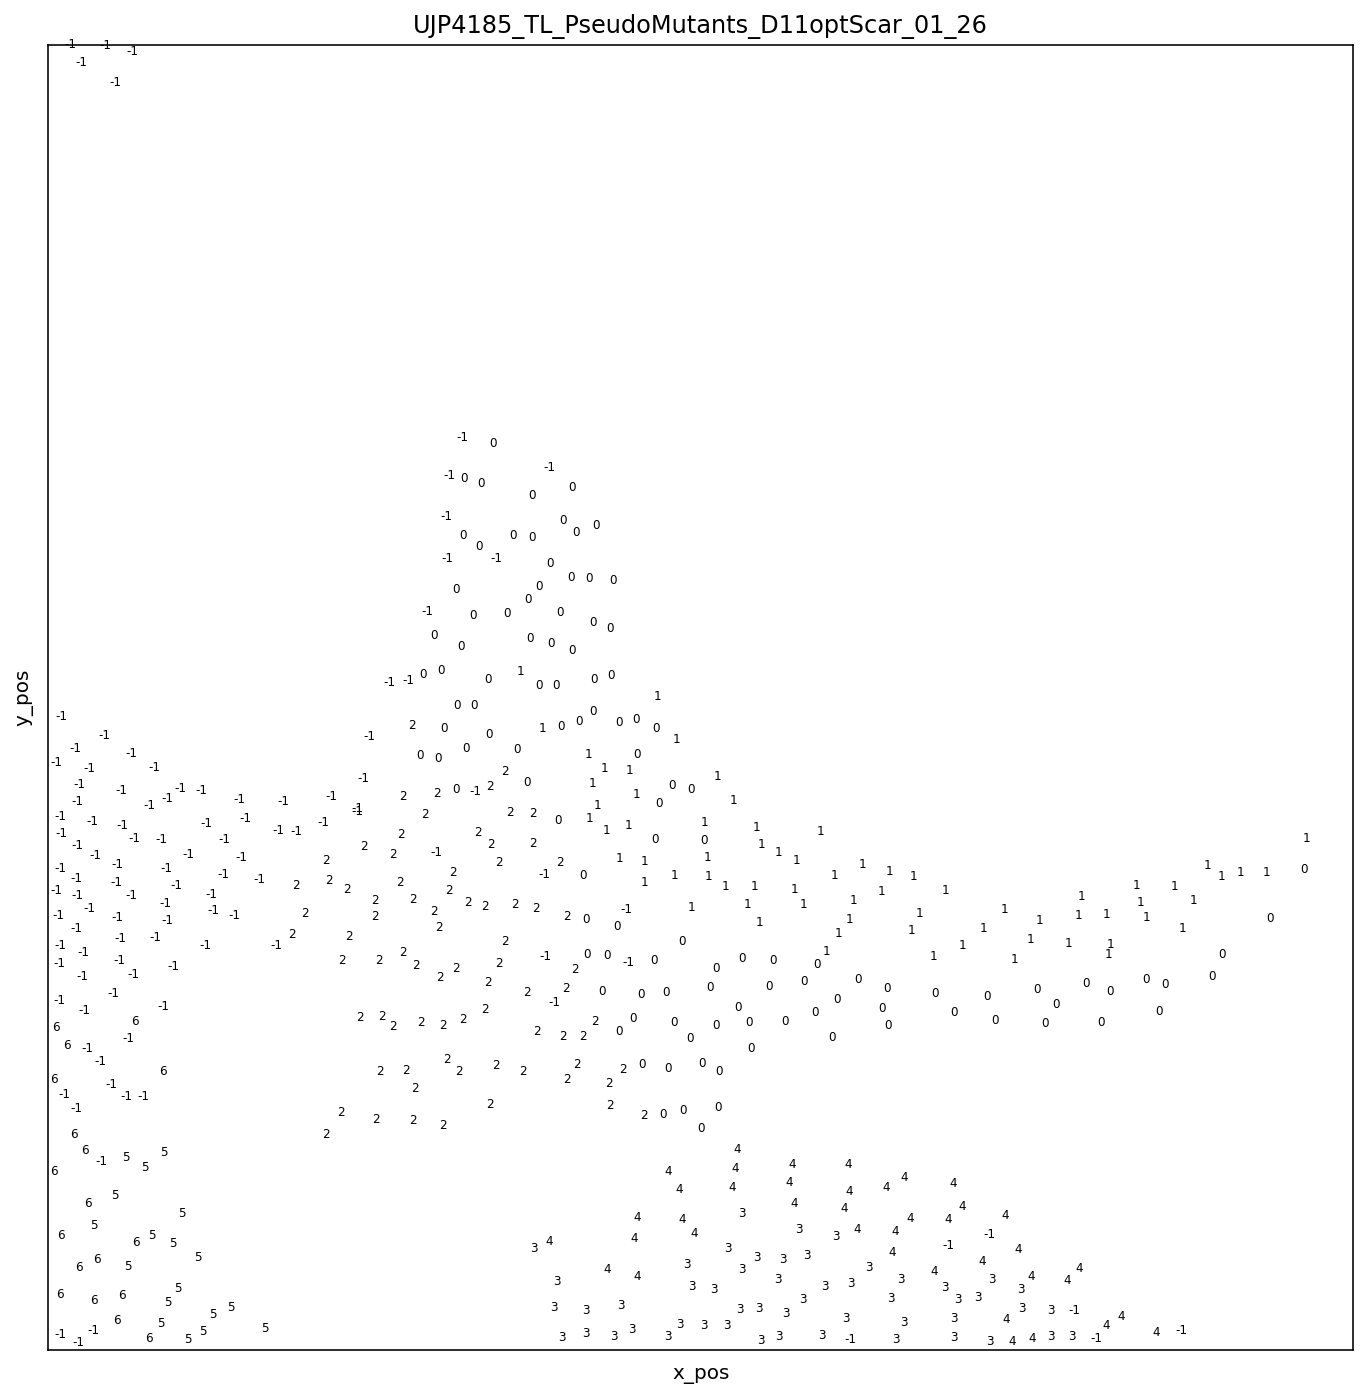

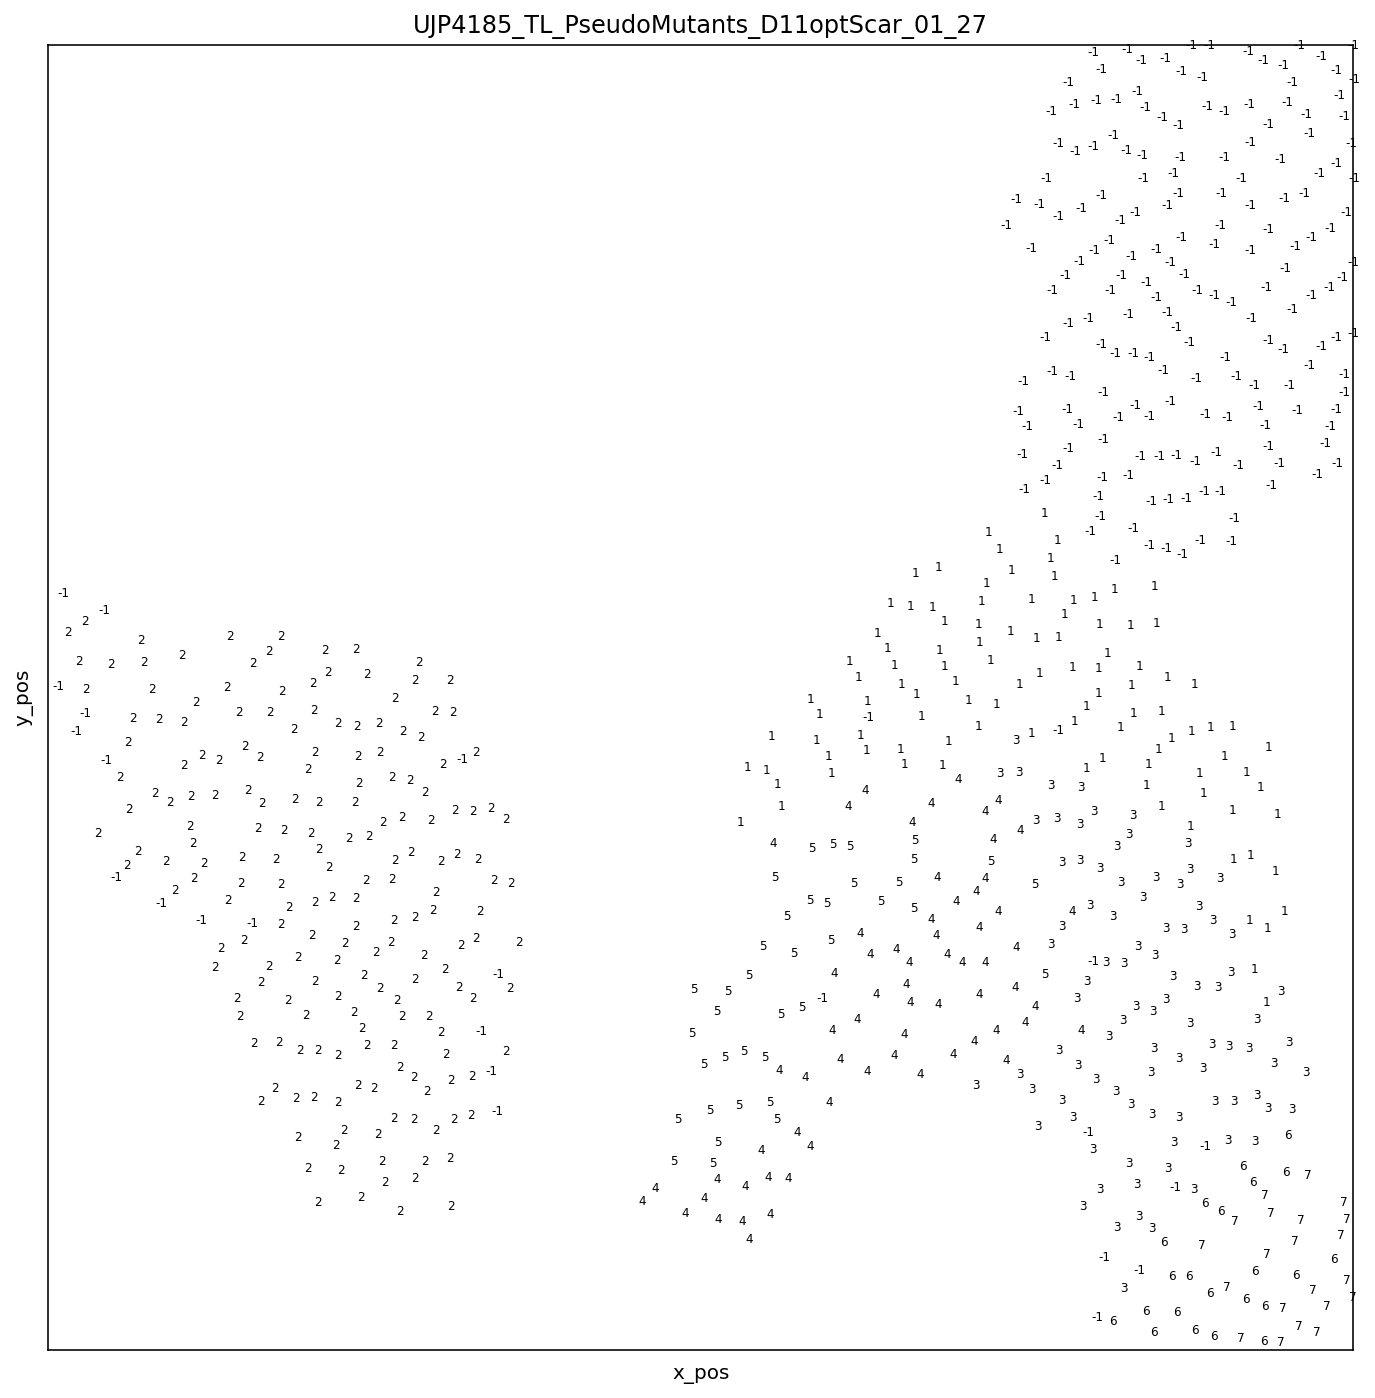

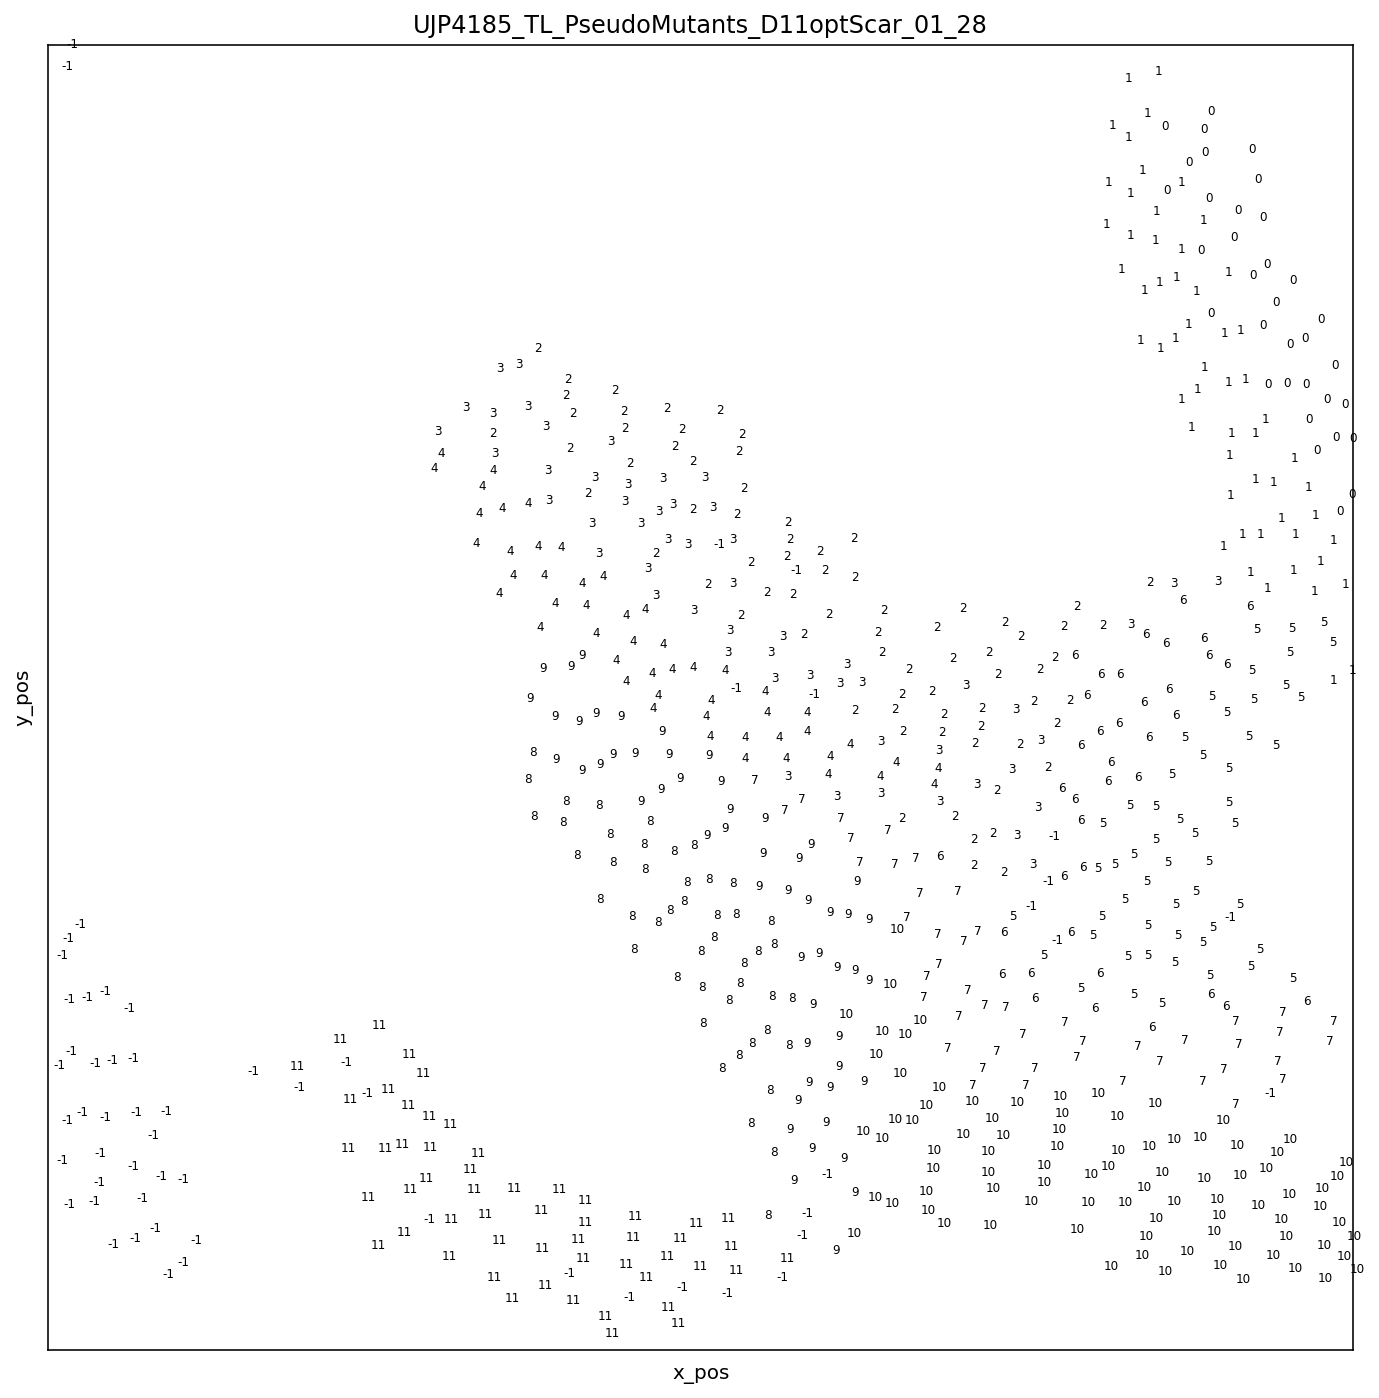

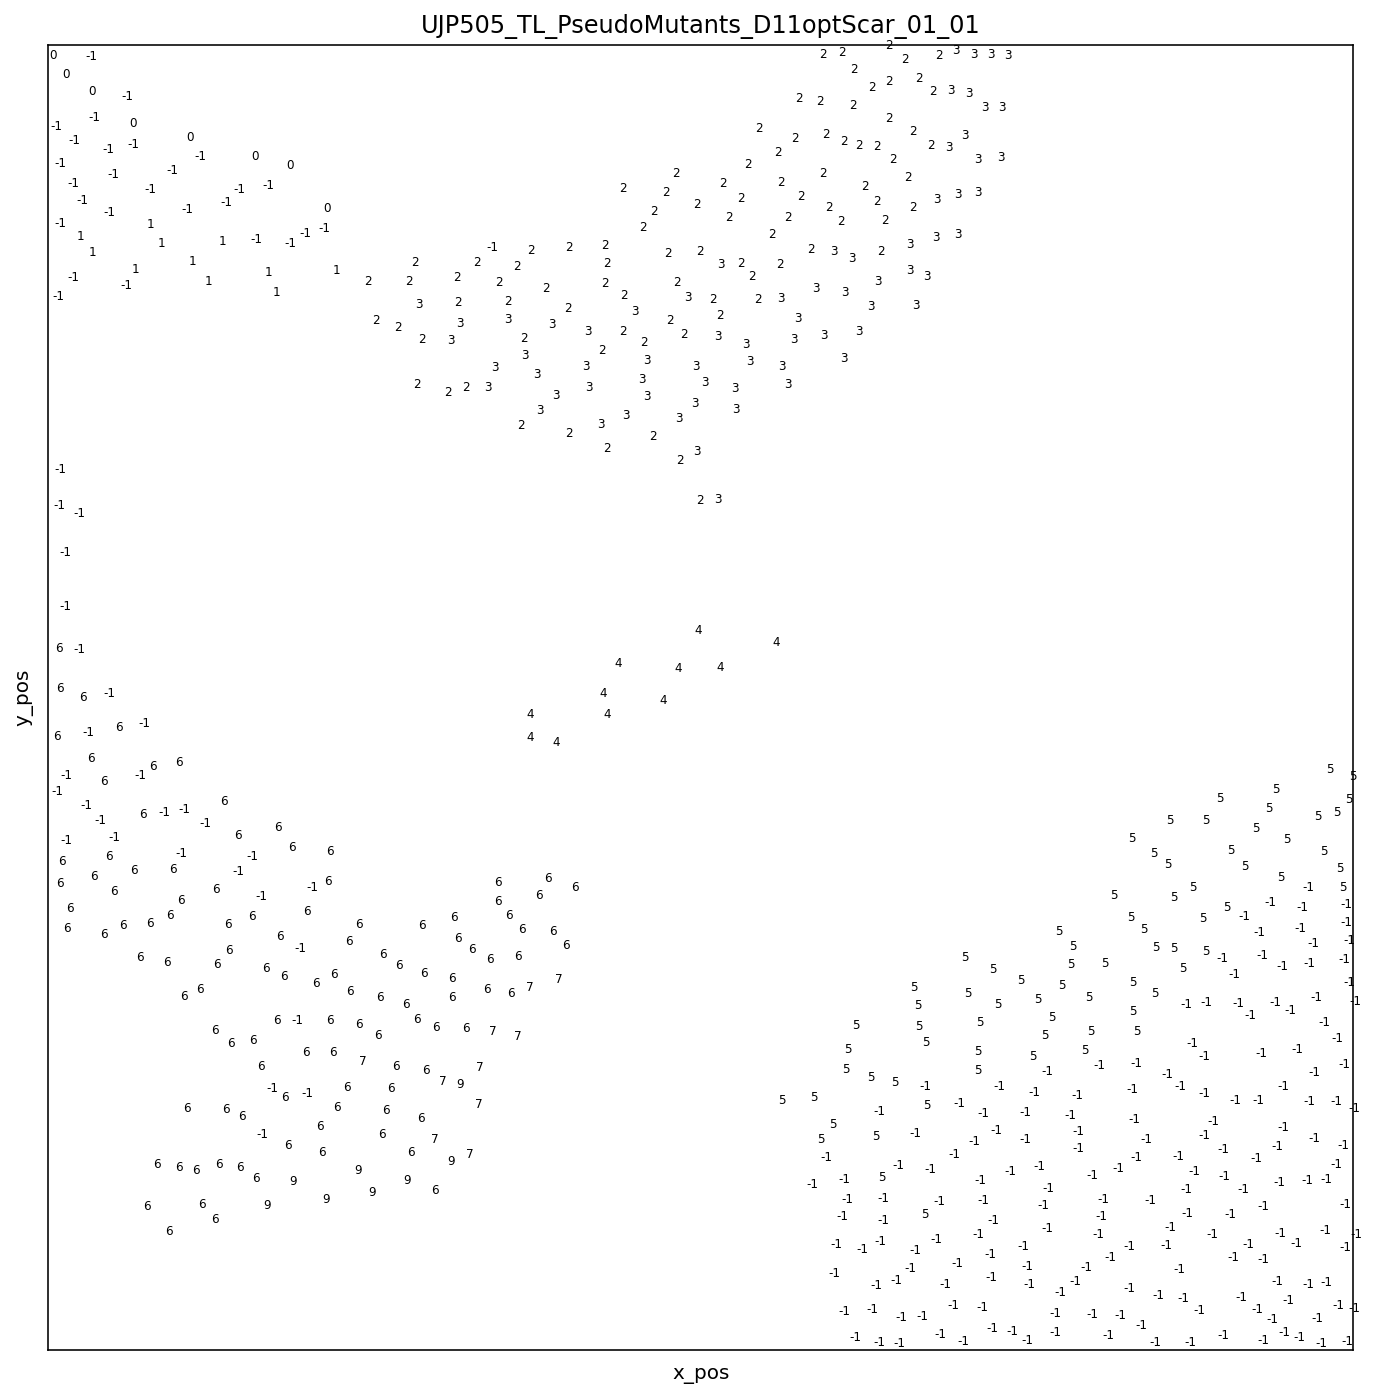

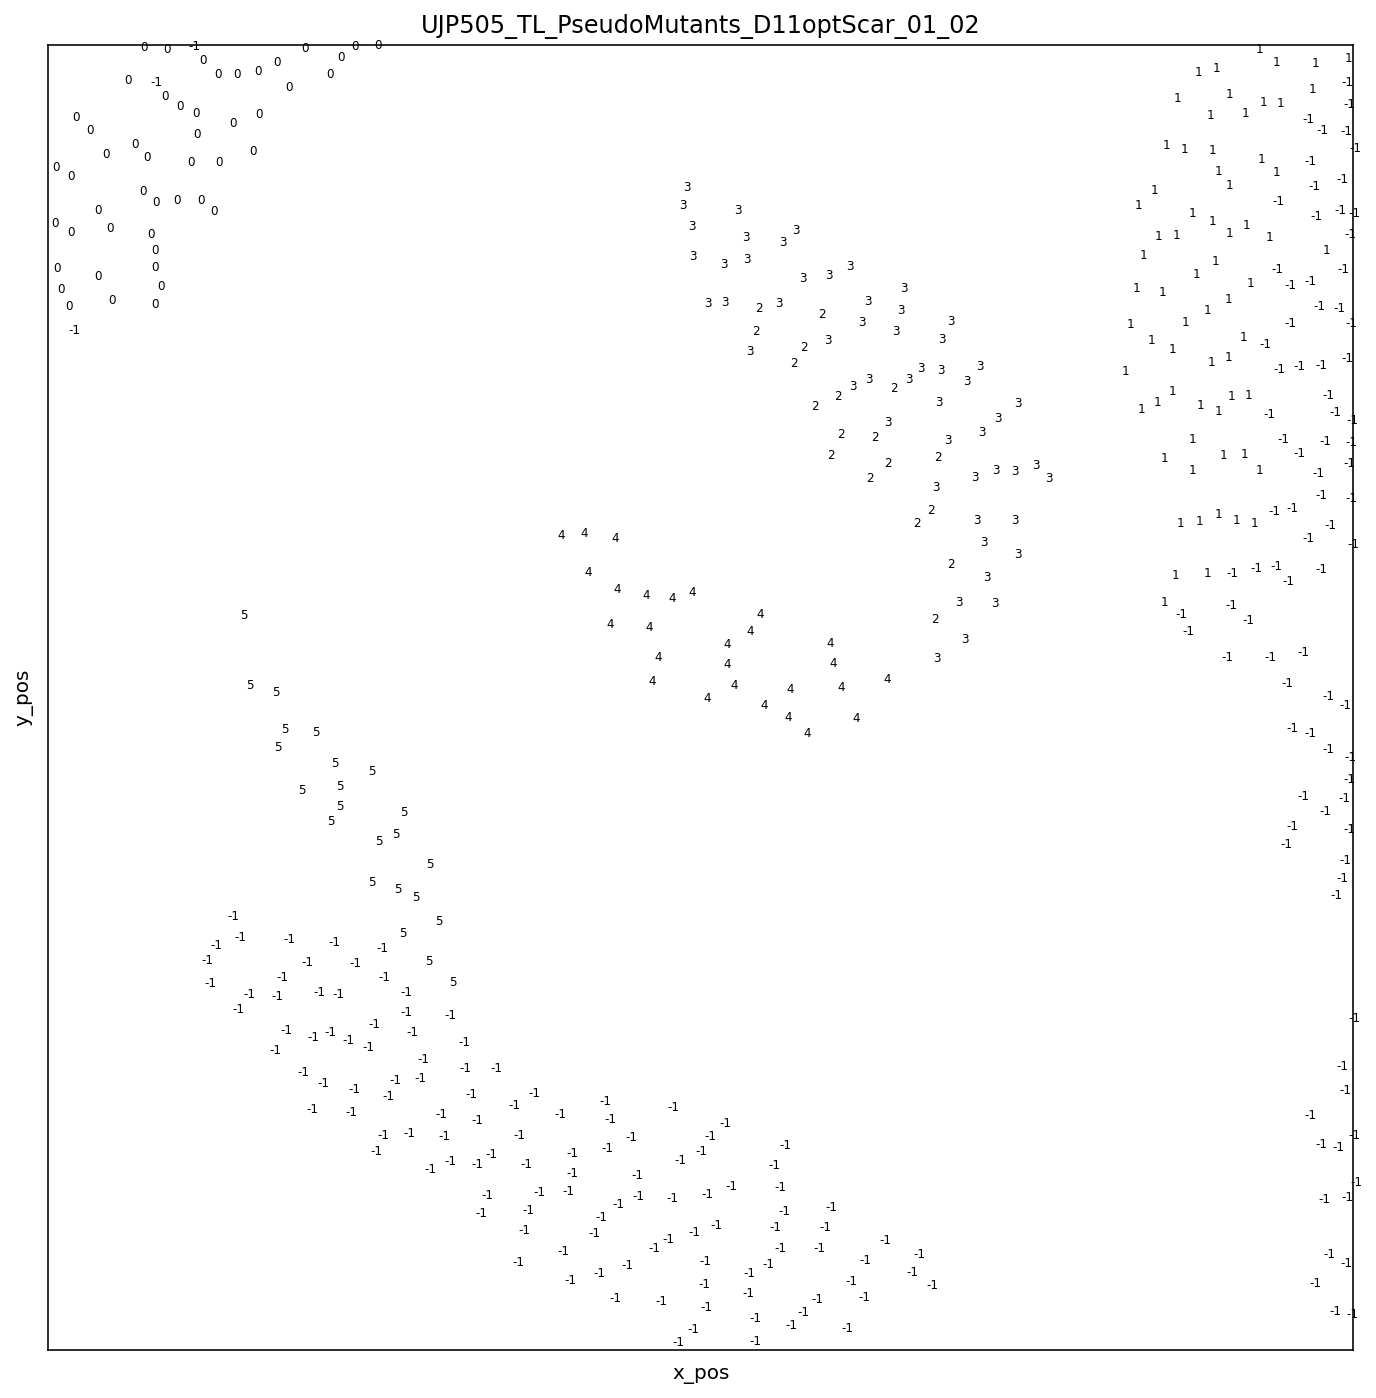

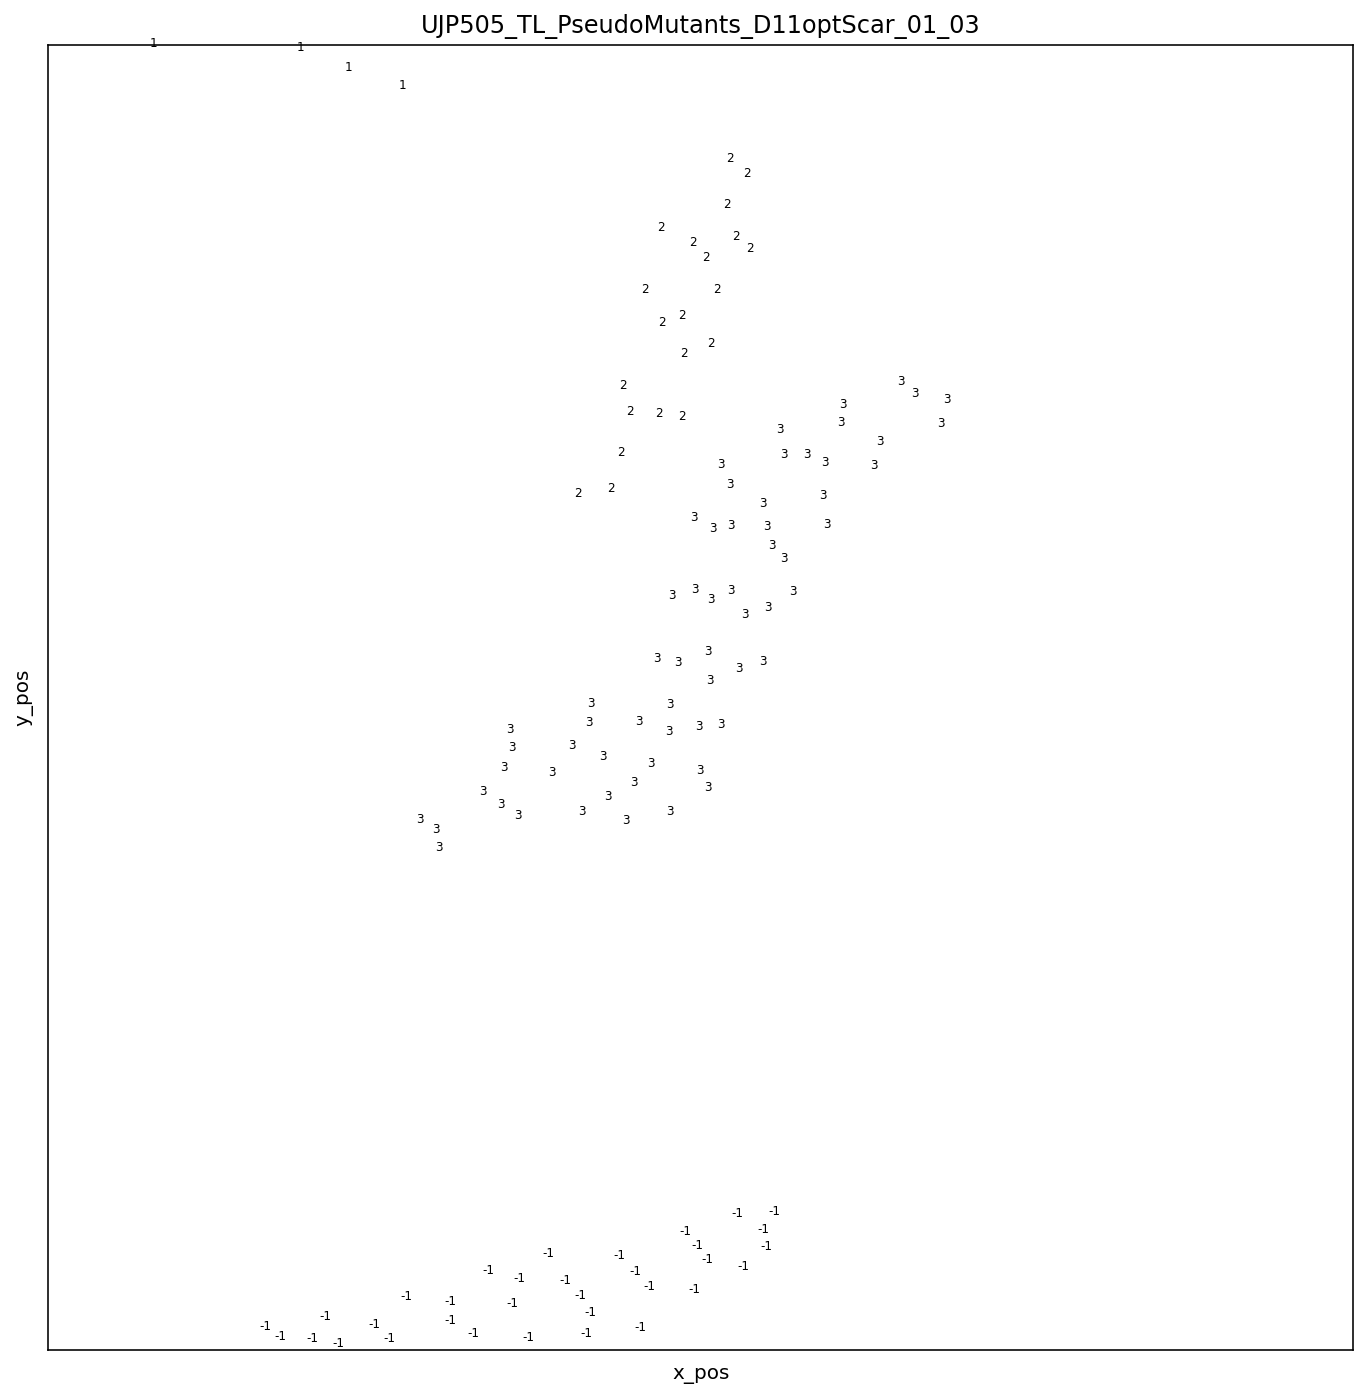

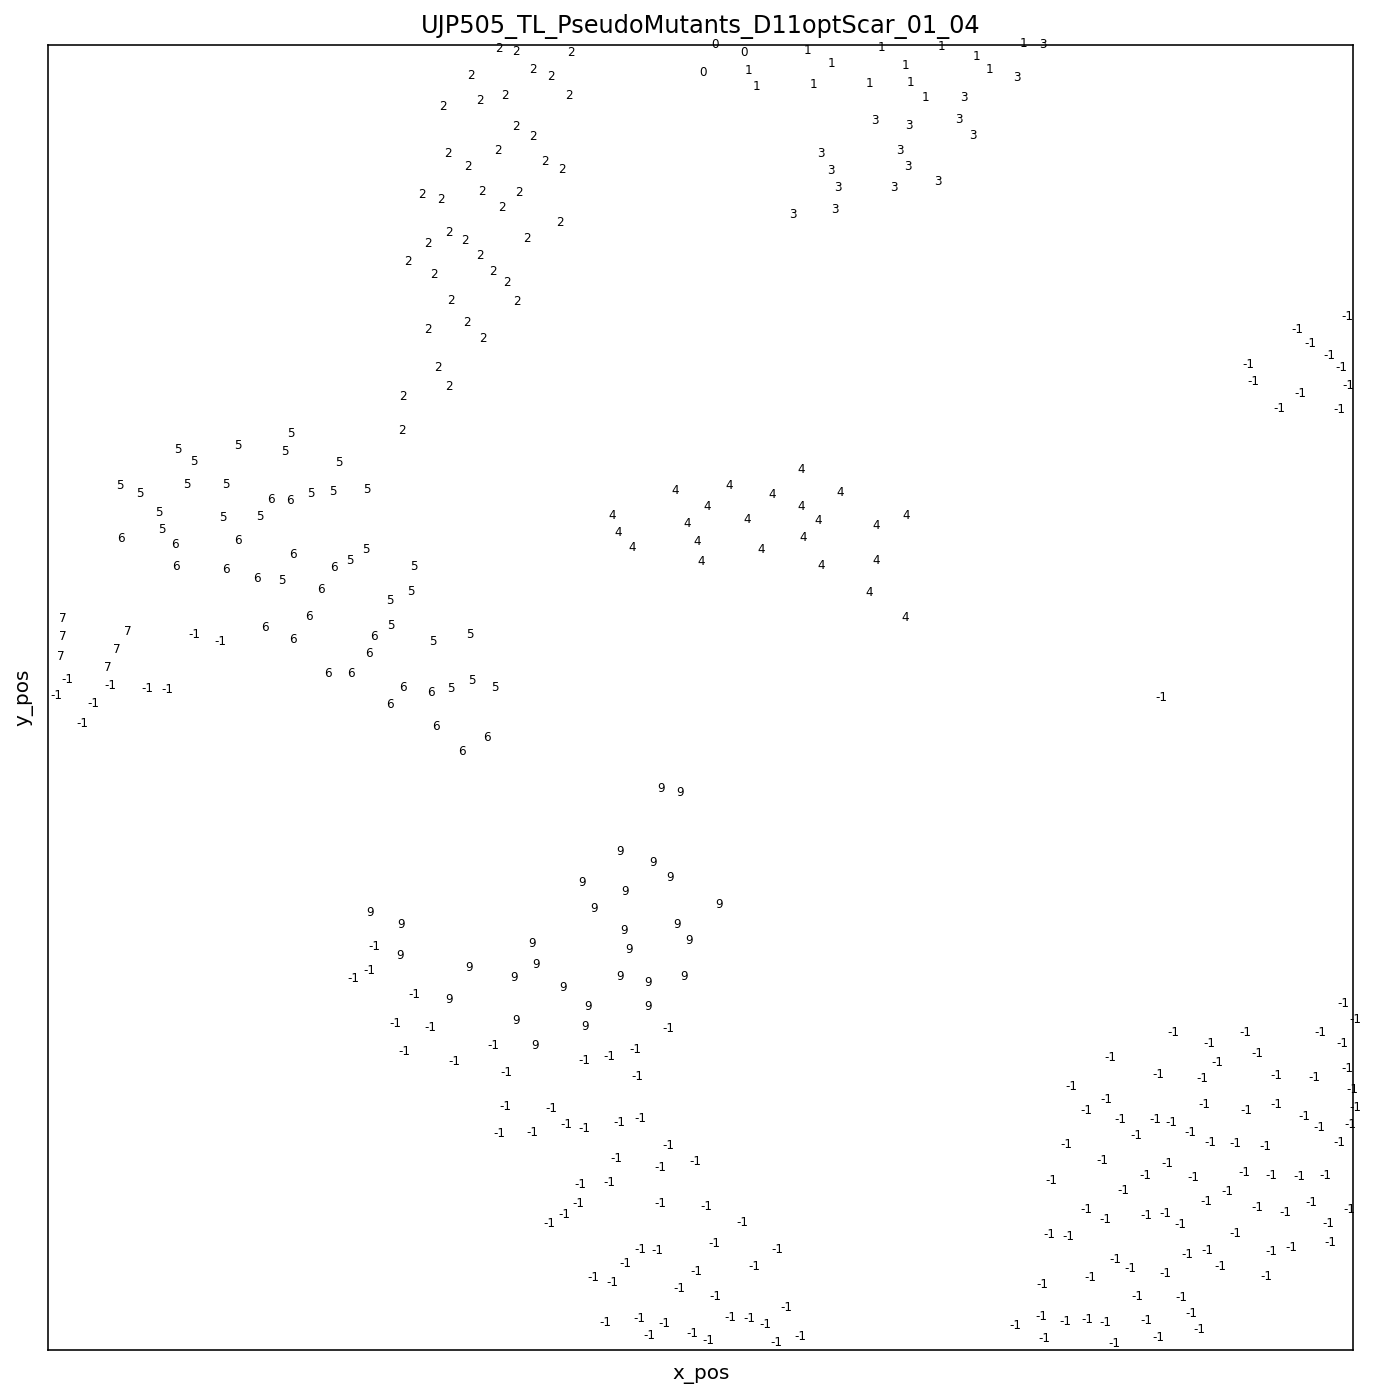

In [4]:
for f in file_names:
    dname = f.replace('.csv','')

    df = pd.read_csv(df_path / f)
    df_end = df[df['frames'] == df['frames'].max().item()].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12,12))
    sns.scatterplot(ax=ax, data=df_end, x='x_pos',y='y_pos', s=0)

    for i in range(df_end.shape[0]):
        plt.text(x=df_end.x_pos[i],y=df_end.y_pos[i],s=df_end.id_colony[i], 
            fontdict=dict(color='black',size=6))
    ax.set_title(dname);    
    ax.set_xlim((0,1024))
    ax.set_ylim((0,1024))
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1)
    fig.patch.set_facecolor('white')
    fig.savefig(save_dir / (dname+'.pdf'))